### Mutual Info and rmse vs no of features

* run fold
* My_Ordinal_Encoding
* make_mi_scores_Regression (Ordinal Vs OHE) and  plot_make_mi_scores
* run fold on different threshold mutual_mxLE[:topk] 
* Graph of rmse using differnt thresh of Mi OHE and differents model
    * Ensemble Models (rf and et) performed better with less features(=50)
    * Xgb model performed better with more features(=80)
    
* Graph of rmse using differnt thresh of Mi_Label_Encode and differents model
    * Ensemble Models (rf and et) performed better with less features(=50)
    * Xgb model performed better with more features(=80)
    


In [2]:
    import pandas as pd
    import numpy as np
    import seaborn as sns

    import warnings
    warnings.filterwarnings('ignore')

    import matplotlib.pyplot as plt
    import seaborn as sns

In [3]:
merged_ordinal = pd.read_csv('ordinal_done.csv')
cats_ordinal = merged_ordinal.select_dtypes(include='object').columns

In [4]:
merged_ordinal.shape

(2919, 83)

In [5]:
cats_ordinal

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'FireplaceQu',
       'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

In [3]:
merged = pd.read_csv('feature_egnr_done.csv')
cats = merged.select_dtypes(include='object').columns

In [5]:
merged[cats].isna().sum()

MSZoning                      4
Street                        0
Alley                      2721
LotShape                      0
LandContour                   0
Utilities                     2
LotConfig                     0
LandSlope                     0
Neighborhood                  0
Condition1                    0
Condition2                    0
BldgType                      0
HouseStyle                    0
RoofStyle                     0
RoofMatl                      0
Exterior1st                   0
Exterior2nd                   0
MasVnrType                    0
Foundation                    0
Heating                       0
FireplaceQu                1420
GarageType                    0
MiscFeature                2814
SaleType                      0
SaleCondition                 0
SalePrice                     0
Street_Alley                  0
LotShape_LandContour          0
LotShape_LotConfig            0
LotShape_LandSlope            0
Condition1_Condition2         0
Exterior

In [4]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=500)

In [5]:
#
from sklearn.ensemble import RandomForestRegressor ,ExtraTreesRegressor
from sklearn.linear_model import Lasso,LinearRegression
from sklearn.metrics import  mean_absolute_error,r2_score,mean_squared_error
las_R = Lasso()
L_R = LinearRegression()
rf = RandomForestRegressor(n_estimators=200)
et= ExtraTreesRegressor(n_estimators=200)
from sklearn.tree import DecisionTreeRegressor
D_R = DecisionTreeRegressor()
# 
#from sklearn.metrics import SCORERS
#SCORERS.keys()

classifier_list= [rf,et,L_R,las_R,D_R]
classifier_name =['rf','et','L_R','las_R','D_R']
scoring ='neg_root_mean_squared_error'

In [26]:
def score_dataset(X, y, model=XGBRegressor()):
    from sklearn.model_selection import cross_val_score
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


NameError: name 'XGBRegressor' is not defined

In [6]:
def run(df,target,model,fold,dropped,save_fold_csv=False):
    from sklearn import model_selection
    from sklearn import metrics ; from sklearn import preprocessing ; from sklearn import impute
    # we create a new column called kfold and fill it with -1
    df["kfold"] = -1
    # the next step is to randomize the rows of the data
    df = df.sample(frac=1).reset_index(drop=True)
    # fetch labels
    y = df[target].values
    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=5)

    for f, (t_, v_) in enumerate(kf.split(X=df, y=y)): # f= fold, t_=train_index ,v_= valid_index
        df.loc[v_, 'kfold'] = f

    #save the new csv with kfold column
    #if save_fold_csv == True:
        #df.to_csv("../input/cat_train_folds.csv", index=False)
    # load the full training data with folds
    # df = pd.read_csv("../input/adult_folds.csv")
    #drop unwanted columns
    df = df.drop(dropped,axis=1)
    
    features = [f for f in df.columns if f not in ("kfold",target)]
    num_col =  [f for f in df.select_dtypes(exclude='object').columns if f not in ("kfold",target)]
    #1. fill all NaN values with NONE
    cat_col = df.select_dtypes(include='object').columns
    for col in cat_col:
    # do not encode the numerical columns
        df.loc[:, col] = df[col].astype(str).fillna("NONE")
        
    #3. fill all NaN values with median
    for col in num_col: 
        imputer = df[col].median()
        df.loc[:, col] = df[col].fillna(imputer)

    #2. label encode the features
    for col in cat_col: 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(df[col])
        df.loc[:, col] = lbl.transform(df[col])
    # get training data using folds
    df_train = df[df.kfold != fold].reset_index(drop=True)
    # get validation data using folds
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    # get training data
    x_train = df_train[features].values
    # get validation data
    x_valid = df_valid[features].values
    # fit model on training data (ohe)
    model.fit(x_train, df_train[target].values)
    # predict on validation data
    # we may need the probability values as we are calculating AUC
    # we will use the probability of 1s
    #valid_preds = model.predict_proba(x_valid)[:, 1]
    valid_prediction = model.predict(x_valid)
    # get roc auc score
    #auc = metrics.roc_auc_score(df_valid[target].values, valid_preds)
    #f1 = metrics.f1_score(df_valid[target].values, valid_prediction)
    MSE = metrics.mean_squared_error(df_valid[target].values, valid_prediction) ; RMSE = np.sqrt(MSE)
    # print auc,f1
    #print(f"Fold = {fold}, AUC = {auc}, F1 = {f1}")
    print(f"Fold = {fold}, RMSE = {RMSE}")
    return(RMSE)

In [7]:
def My_Ordinal_Encoding(train):    
    mx_LE = train.copy()
    for colname in mx_LE.select_dtypes(["category", "object"]):
        mx_LE[colname], _ = mx_LE[colname].factorize()
    return mx_LE


In [17]:
mxLE = My_Ordinal_Encoding(train_df)

In [139]:
mxLE.to_csv('data/train_df_label_encoded.csv',index=False)

In [34]:
def My_One_Hot_Encoding(train,cats_train,nums_train):
    OHE_dum = pd.get_dummies(train[cats_train],drop_first=True)
    OHE = pd.concat([OHE_dum,train[nums_train]],axis=1)
    return OHE

In [84]:
OHE_df= train_df.drop(drops,axis=1)
OHE_cats= OHE_df.select_dtypes(include='object').columns
OHE_nums= OHE_df.select_dtypes(exclude='object').columns
mxOHE= My_One_Hot_Encoding(train=OHE_df,cats_train=OHE_cats,nums_train=OHE_nums)

In [142]:
mxOHE.to_csv('data/train_df_OHE_encoded.csv',index=False)

In [85]:
#OHE_cats= OHE_df.select_dtypes(include='object').columns
OHE_cats

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'FireplaceQu', 'GarageType', 'SaleType', 'SaleCondition',
       'Street_Alley', 'LotShape_LandContour', 'LotShape_LotConfig',
       'LotShape_LandSlope', 'Condition1_Condition2',
       'Exterior1st_Exterior2nd', 'Foundation_MasVnrType',
       'SaleCondition_SaleType'],
      dtype='object')

In [9]:
train_df = merged.loc[merged.SalePrice!='test_col'].reset_index(drop=True)
test_df = merged.loc[merged.SalePrice =='test_col'].reset_index(drop=True)
train_df.SalePrice = train_df.SalePrice.apply(int)

In [12]:
target = 'SalePrice'

In [10]:
drops =['Id','Utilities','Street','Alley','area_per_finishes','RoofMatl','YearBuilt','YearRemodAdd','YrSold',
       'MiscFeature','Heating']

In [13]:
for i in np.arange(5):
    run(df=train_df,target=target,model=et,fold=i,dropped=drops,save_fold_csv=False)

Fold = 0, RMSE = 30178.970638478535
Fold = 1, RMSE = 26997.772468665346
Fold = 2, RMSE = 29158.20904358494
Fold = 3, RMSE = 24867.529696017096
Fold = 4, RMSE = 31841.384138459554


In [19]:
merged.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities',
       ...
       'total_Ext_Ql_Cd', 'total_Bmt_Ql_Cd', 'total_Garage_Ql_Cd',
       'total_Bmt_Fn_Area', 'Bsmt_Fsh_Per', 'avg_Ext_Qual', 'avg_Bmt_Qual',
       'avg_Gar_Qual', 'total_All_Qualities', 'avg_All_Qualities'],
      dtype='object', length=119)

In [25]:
for i in np.arange(5):
    RMSE_arr=[]
    score= run(df=train_df,target=target,model=rf,fold=i,dropped=drops,save_fold_csv=False)  ; RMSE_arr.append(score)
print('mean_score = ', np.mean(RMSE_arr))

Fold = 0, RMSE = 35082.95008378144
Fold = 1, RMSE = 34122.13026188192
Fold = 2, RMSE = 33690.859521515275
Fold = 3, RMSE = 29592.85186061056
Fold = 4, RMSE = 25809.646577135303
mean_score =  25809.646577135303


In [106]:
for model in classifier_list:
    RMSE_arr=[]
    print('Model : ',model)
    for i in np.arange(5):
        score= run(df=train_df,target=target,model=model,fold=i,dropped=drops,save_fold_csv=False)  ; RMSE_arr.append(score)
    print('')
    print('___mean_score___ = ', np.mean(RMSE_arr))
    print('===============================================')

Model :  RandomForestRegressor(n_estimators=200)
Fold = 0, RMSE = 25913.49529777747
Fold = 1, RMSE = 34855.583868716894
Fold = 2, RMSE = 27119.831174047467
Fold = 3, RMSE = 32753.14492297116
Fold = 4, RMSE = 27072.10730206559

___mean_score___ =  29542.832513115718
Model :  ExtraTreesRegressor(n_estimators=200)
Fold = 0, RMSE = 22294.794061528304
Fold = 1, RMSE = 33800.87820354451
Fold = 2, RMSE = 28111.907173437976
Fold = 3, RMSE = 20423.756109791357
Fold = 4, RMSE = 33128.36081994491

___mean_score___ =  27551.93927364941
Model :  LinearRegression()
Fold = 0, RMSE = 59676.937097717855
Fold = 1, RMSE = 46797.40674922767
Fold = 2, RMSE = 48189.05265188178
Fold = 3, RMSE = 26157.60079532438
Fold = 4, RMSE = 33529.13211613511

___mean_score___ =  42870.02588205736
Model :  Lasso()
Fold = 0, RMSE = 28446.291489955787
Fold = 1, RMSE = 31305.357488467456
Fold = 2, RMSE = 48793.857079029505
Fold = 3, RMSE = 27198.430621884556
Fold = 4, RMSE = 27389.967118907218

___mean_score___ =  32626.780

In [14]:
base_et=['OverallQual', 'total_indoor_sqft','total_All_Qualities','avg_All_Qualities','GarageCars','ExterQual','GrLivArea',
         'KitchenQual','BsmtQual','FullBath','2ndFlrSF','1stFlrSF','TotalBsmtSF','YearBuilt','GarageArea',
         'total_in_out_sqft','no_finishes','YrSd_YrBlt','Fireplaces','BsmtFinSF1', 'total_Bmt_Fn_Area','TotRmsAbvGrd'
         ,'YearBuilt_Age','YearRemodAdd_Age','CentralAir','MasVnrArea','total_outdoor_sqft','YearRemodAdd', 
         'BedroomAbvGr','total_Ext_Ql_Cd','LotArea','YrSd_YrRmd','total_Bmt_Ql_Cd','BsmtExposure','GarageYrBlt',
 'LotAreaPerFront','avg_Bmt_Qual','total_Max_Porch_Area','OpenPorchSF','OverallCond','SalePrice']

In [29]:
#base et...
for i in np.arange(5):
    RMSE_arr=[]
    score= run(df=train_df[base_et],target=target,model=rf,fold=i,dropped=[],save_fold_csv=False)  ; RMSE_arr.append(score)
print('mean_score = ', np.mean(RMSE_arr))

Fold = 0, RMSE = 22409.958336462863
Fold = 1, RMSE = 33049.06142087852
Fold = 2, RMSE = 24183.832616168933
Fold = 3, RMSE = 33553.1592527274
Fold = 4, RMSE = 30138.649733091297
mean_score =  30138.649733091297


In [108]:
for model in classifier_list:
    RMSE_arr=[]
    print('Model : ',model)
    for i in np.arange(5):
        score= run(df=train_df[base_et],target=target,model=model,fold=i,dropped=drops,save_fold_csv=False)  ; RMSE_arr.append(score)
    print('')
    print('___mean_score___ = ', np.mean(RMSE_arr))
    print('===============================================')

Model :  RandomForestRegressor(n_estimators=200)


KeyError: "['Id' 'Utilities' 'Street' 'Alley' 'area_per_finishes' 'RoofMatl' 'YrSold'\n 'MiscFeature' 'Heating'] not found in axis"

In [15]:
def Fill_Num_NAN(df,target):
    nums = df.select_dtypes(exclude='object').columns
    for col in nums.drop(target): 
        imputer = df[col].median()
        df.loc[:, col] = df[col].fillna(imputer)
    return df

In [18]:
#numerical = train_df.select_dtypes(exclude='object')
mxLE =Fill_Num_NAN(mxLE,"SalePrice")

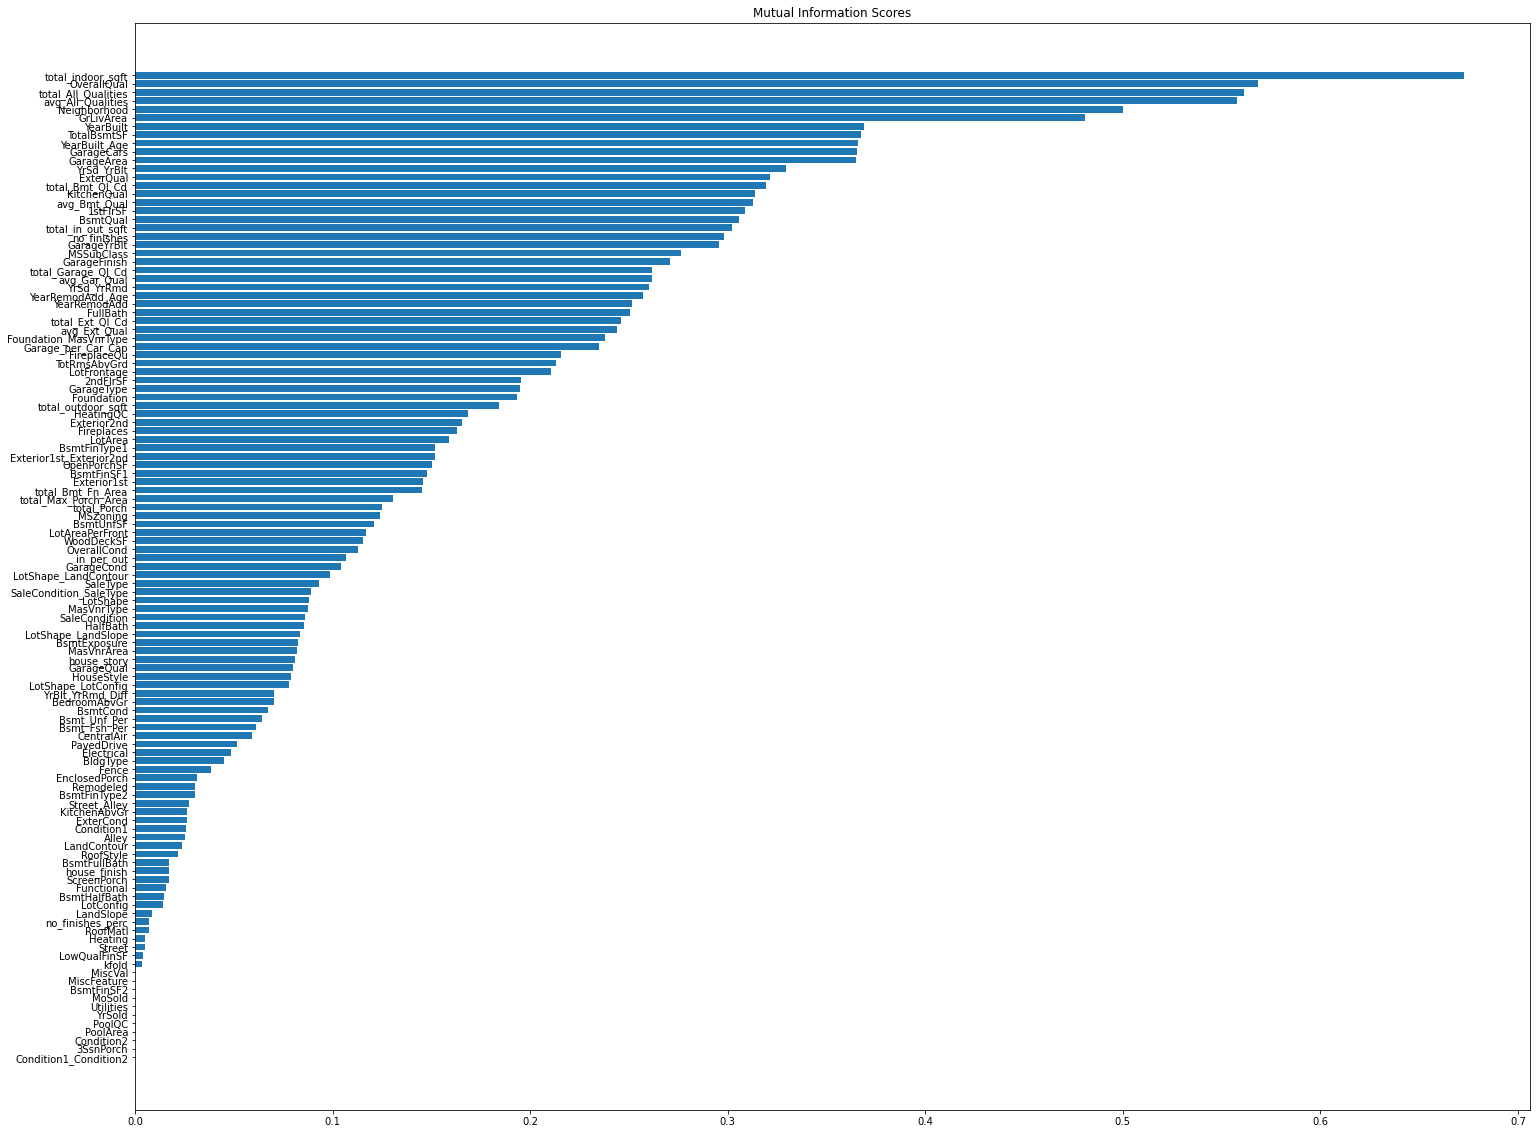

In [19]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores_Regression(X_train, y_train):    
    discrete_features = X_train.dtypes == int
    mi_scores = mutual_info_regression(X_train, y_train, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

scoremxLE = make_mi_scores_Regression(X_train=mxLE.drop(['Id','SalePrice','area_per_finishes'],axis=1), y_train=train_df.SalePrice)

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(25,20))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
plot_mi_scores(scoremxLE)

In [86]:
mxOHE.loc[:,target]= train_df[target]

In [87]:
mxOHE.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,...,total_Bmt_Ql_Cd,total_Garage_Ql_Cd,total_Bmt_Fn_Area,Bsmt_Fsh_Per,avg_Ext_Qual,avg_Bmt_Qual,avg_Gar_Qual,total_All_Qualities,avg_All_Qualities,kfold
0,0,0,1,0,1,0,0,1,0,0,...,25.0,16,706.0,0.175234,6.0,5.0,4.0,59.0,5.363636,-1
1,0,0,1,0,1,0,0,1,0,1,...,23.0,16,978.0,0.225040,5.0,4.6,4.0,58.6,5.327273,-1
2,0,0,1,0,0,0,0,1,0,0,...,26.0,16,486.0,0.471739,6.0,5.2,4.0,60.2,5.472727,-1
3,0,0,1,0,0,0,0,1,0,0,...,20.0,14,216.0,0.714286,5.0,4.0,3.5,54.5,4.954545,-1
4,0,0,1,0,0,0,0,1,0,1,...,27.0,16,655.0,0.427948,6.0,5.4,4.0,61.4,5.581818,-1


In [88]:
#numerical = train_df.select_dtypes(exclude='object')
mxOHE =Fill_Num_NAN(mxOHE,"SalePrice")

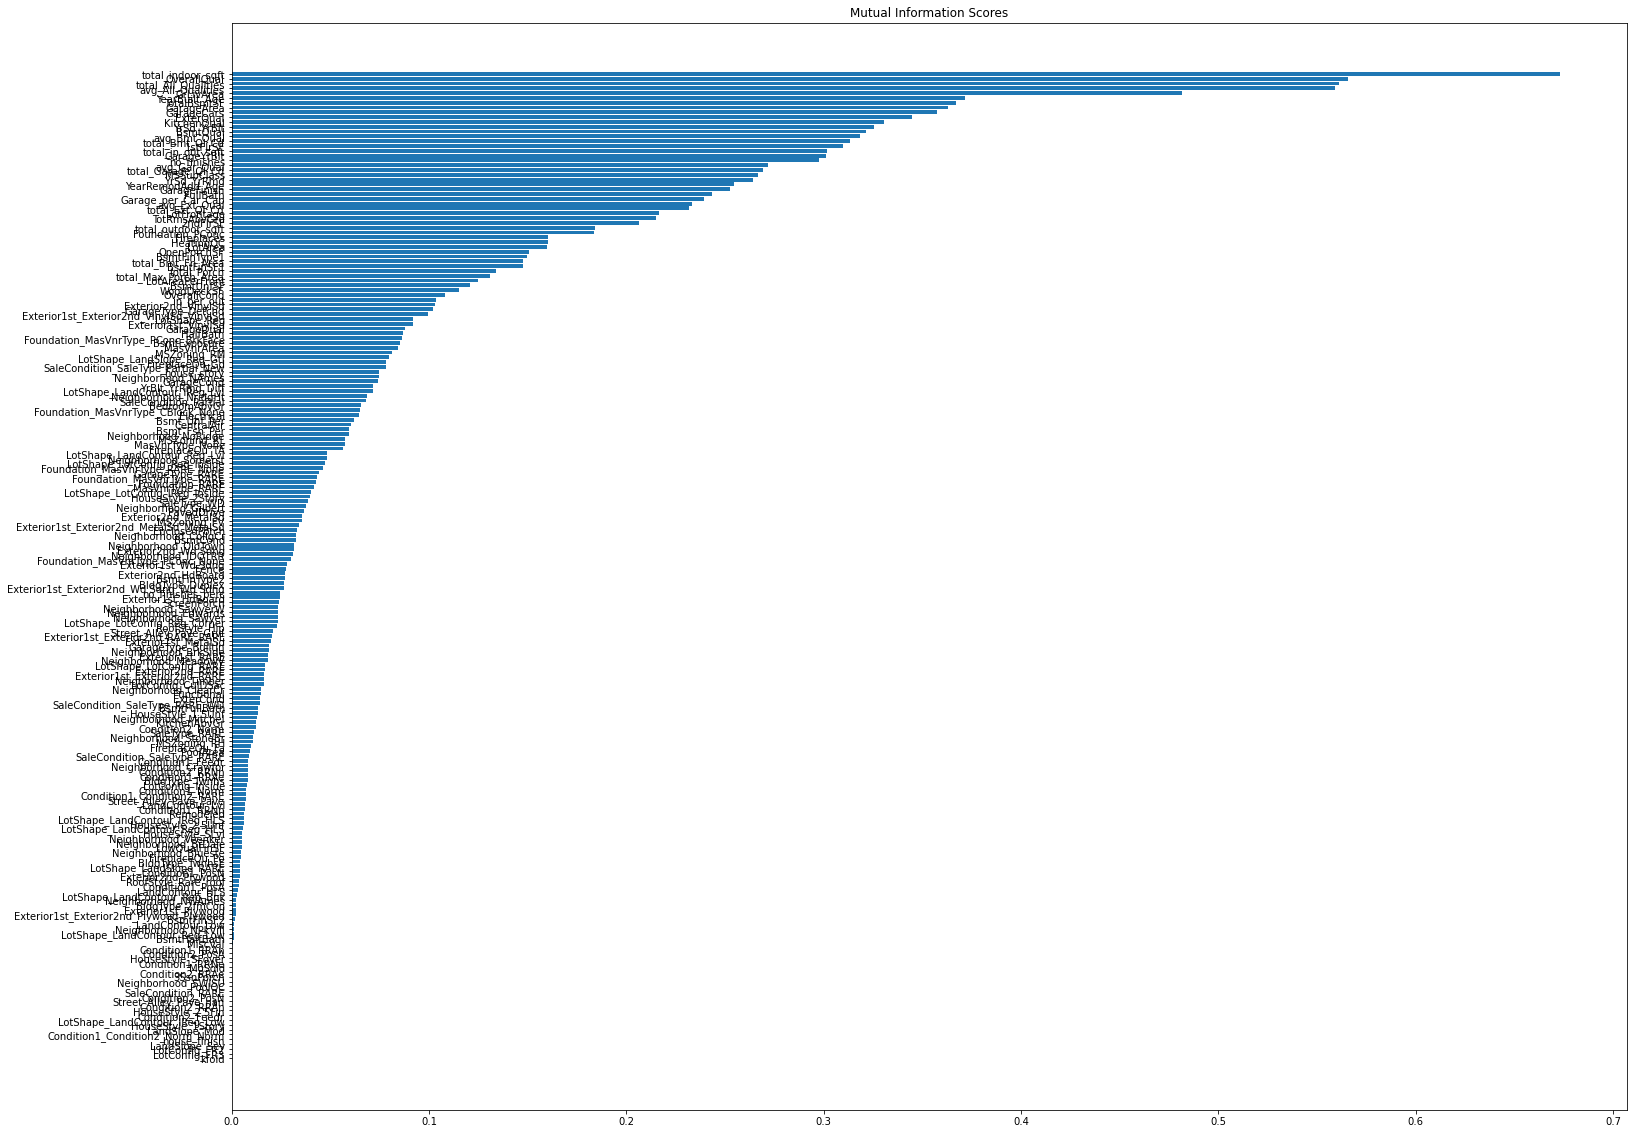

In [89]:
scoremOHE = make_mi_scores_Regression(X_train=mxOHE.drop(['SalePrice'],axis=1), y_train=train_df.SalePrice)

plot_mi_scores(scoremOHE)

In [143]:
mutual_mxOHE=scoremOHE.index.to_list()
mutual_mxOHE

['total_indoor_sqft',
 'OverallQual',
 'total_All_Qualities',
 'avg_All_Qualities',
 'GrLivArea',
 'YearBuilt_Age',
 'TotalBsmtSF',
 'GarageArea',
 'GarageCars',
 'ExterQual',
 'KitchenQual',
 'YrSd_YrBlt',
 'BsmtQual',
 'avg_Bmt_Qual',
 'total_Bmt_Ql_Cd',
 '1stFlrSF',
 'total_in_out_sqft',
 'GarageYrBlt',
 'no_finishes',
 'avg_Gar_Qual',
 'total_Garage_Ql_Cd',
 'MSSubClass',
 'YrSd_YrRmd',
 'YearRemodAdd_Age',
 'GarageFinish',
 'FullBath',
 'Garage_per_Car_Cap',
 'avg_Ext_Qual',
 'total_Ext_Ql_Cd',
 'LotFrontage',
 'TotRmsAbvGrd',
 '2ndFlrSF',
 'total_outdoor_sqft',
 'Foundation_PConc',
 'Fireplaces',
 'HeatingQC',
 'LotArea',
 'OpenPorchSF',
 'BsmtFinType1',
 'total_Bmt_Fn_Area',
 'BsmtFinSF1',
 'total_Porch',
 'total_Max_Porch_Area',
 'LotAreaPerFront',
 'BsmtUnfSF',
 'WoodDeckSF',
 'OverallCond',
 'in_per_out',
 'Exterior2nd_VinylSd',
 'GarageType_Detchd',
 'Exterior1st_Exterior2nd_VinylSd_VinylSd',
 'LotShape_Reg',
 'Exterior1st_VinylSd',
 'GarageQual',
 'HalfBath',
 'Foundation_M

In [22]:
mutual_mxLE

['total_indoor_sqft',
 'OverallQual',
 'total_All_Qualities',
 'avg_All_Qualities',
 'Neighborhood',
 'GrLivArea',
 'YearBuilt',
 'TotalBsmtSF',
 'YearBuilt_Age',
 'GarageCars',
 'GarageArea',
 'YrSd_YrBlt',
 'ExterQual',
 'total_Bmt_Ql_Cd',
 'KitchenQual',
 'avg_Bmt_Qual',
 '1stFlrSF',
 'BsmtQual',
 'total_in_out_sqft',
 'no_finishes',
 'GarageYrBlt',
 'MSSubClass',
 'GarageFinish',
 'total_Garage_Ql_Cd',
 'avg_Gar_Qual',
 'YrSd_YrRmd',
 'YearRemodAdd_Age',
 'YearRemodAdd',
 'FullBath',
 'total_Ext_Ql_Cd',
 'avg_Ext_Qual',
 'Foundation_MasVnrType',
 'Garage_per_Car_Cap',
 'FireplaceQu',
 'TotRmsAbvGrd',
 'LotFrontage',
 '2ndFlrSF',
 'GarageType',
 'Foundation',
 'total_outdoor_sqft',
 'HeatingQC',
 'Exterior2nd',
 'Fireplaces',
 'LotArea',
 'BsmtFinType1',
 'Exterior1st_Exterior2nd',
 'OpenPorchSF',
 'BsmtFinSF1',
 'Exterior1st',
 'total_Bmt_Fn_Area',
 'total_Max_Porch_Area',
 'total_Porch',
 'MSZoning',
 'BsmtUnfSF',
 'LotAreaPerFront',
 'WoodDeckSF',
 'OverallCond',
 'in_per_out',
 

In [92]:
topK_mutual_mxOHE

['total_indoor_sqft',
 'OverallQual',
 'total_All_Qualities',
 'avg_All_Qualities',
 'GrLivArea',
 'YearBuilt_Age',
 'TotalBsmtSF',
 'GarageArea',
 'GarageCars',
 'ExterQual',
 'KitchenQual',
 'YrSd_YrBlt',
 'BsmtQual',
 'avg_Bmt_Qual',
 'total_Bmt_Ql_Cd',
 '1stFlrSF',
 'total_in_out_sqft',
 'GarageYrBlt',
 'no_finishes',
 'avg_Gar_Qual',
 'total_Garage_Ql_Cd',
 'MSSubClass',
 'YrSd_YrRmd',
 'YearRemodAdd_Age',
 'GarageFinish',
 'FullBath',
 'Garage_per_Car_Cap',
 'avg_Ext_Qual',
 'total_Ext_Ql_Cd',
 'LotFrontage',
 'TotRmsAbvGrd',
 '2ndFlrSF',
 'total_outdoor_sqft',
 'Foundation_PConc',
 'Fireplaces',
 'HeatingQC',
 'LotArea',
 'OpenPorchSF',
 'BsmtFinType1',
 'total_Bmt_Fn_Area',
 'BsmtFinSF1',
 'total_Porch',
 'total_Max_Porch_Area',
 'LotAreaPerFront',
 'BsmtUnfSF',
 'WoodDeckSF',
 'OverallCond',
 'in_per_out',
 'Exterior2nd_VinylSd',
 'GarageType_Detchd',
 'Exterior1st_Exterior2nd_VinylSd_VinylSd',
 'LotShape_Reg',
 'Exterior1st_VinylSd',
 'GarageQual',
 'HalfBath',
 'Foundation_M

In [21]:
mutual_mxLE=scoremxLE.index.to_list()

In [55]:
topK_mutual_mxLE = mutual_mxLE[:40]

In [56]:
topK_mutual_mxLE

['total_indoor_sqft',
 'OverallQual',
 'avg_All_Qualities',
 'total_All_Qualities',
 'Neighborhood',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageArea',
 'YearBuilt_Age',
 'YearBuilt',
 'GarageCars',
 'YrSd_YrBlt',
 'avg_Bmt_Qual',
 'KitchenQual',
 'ExterQual',
 'total_Bmt_Ql_Cd',
 'BsmtQual',
 '1stFlrSF',
 'total_in_out_sqft',
 'GarageYrBlt',
 'no_finishes',
 'MSSubClass',
 'avg_Gar_Qual',
 'GarageFinish',
 'total_Garage_Ql_Cd',
 'FullBath',
 'YrSd_YrRmd',
 'YearRemodAdd_Age',
 'YearRemodAdd',
 'avg_Ext_Qual',
 'Garage_per_Car_Cap',
 'Foundation_MasVnrType',
 'TotRmsAbvGrd',
 'total_Ext_Ql_Cd',
 '2ndFlrSF',
 'LotFrontage',
 'FireplaceQu',
 'GarageType',
 'Foundation',
 'total_outdoor_sqft']

total_indoor_sqft


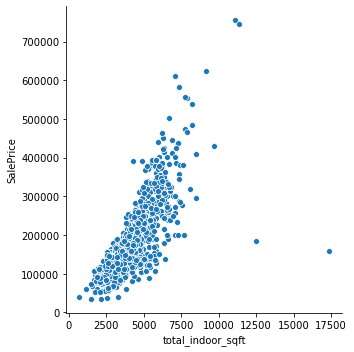

OverallQual


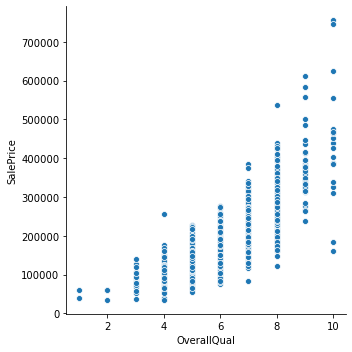

total_All_Qualities


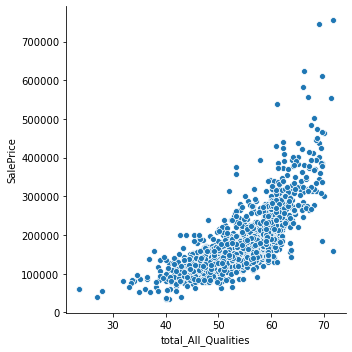

avg_All_Qualities


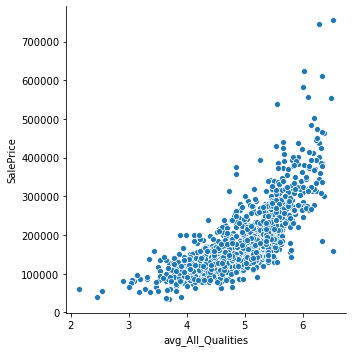

Neighborhood


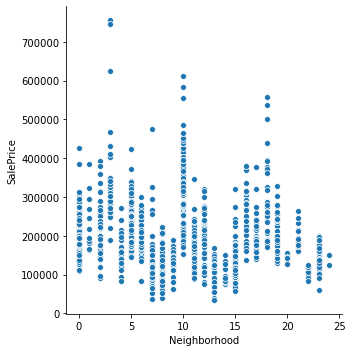

GrLivArea


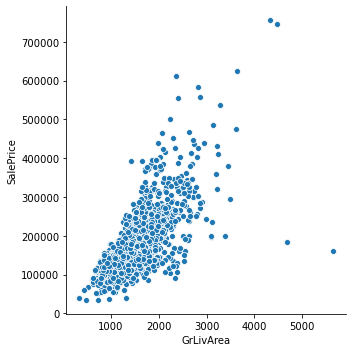

YearBuilt


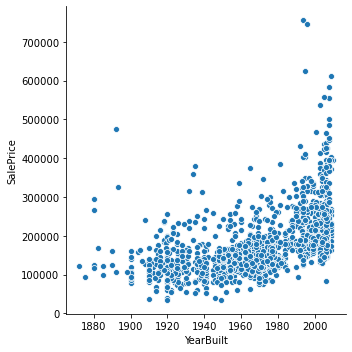

TotalBsmtSF


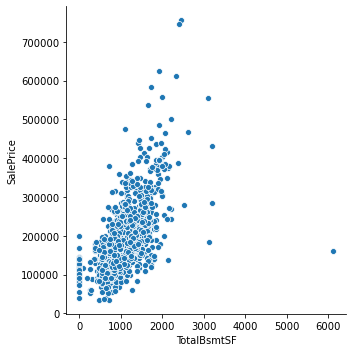

YearBuilt_Age


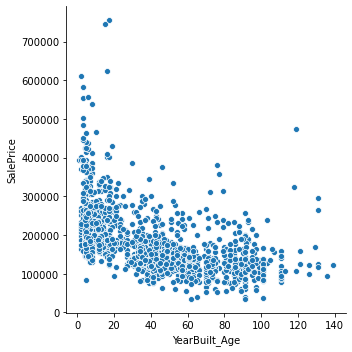

GarageCars


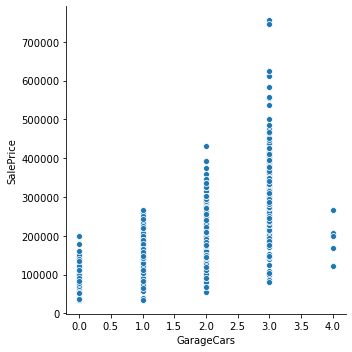

GarageArea


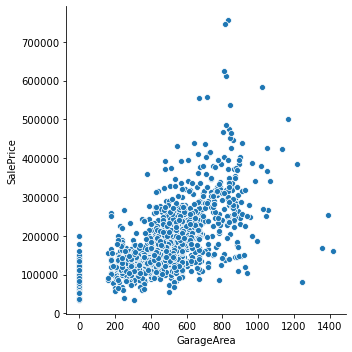

YrSd_YrBlt


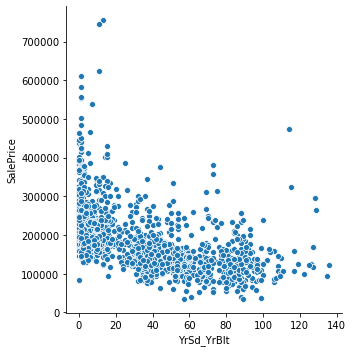

ExterQual


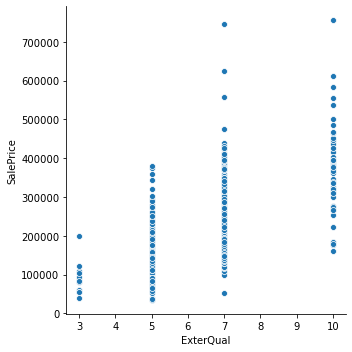

total_Bmt_Ql_Cd


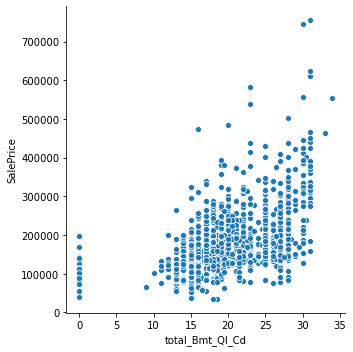

KitchenQual


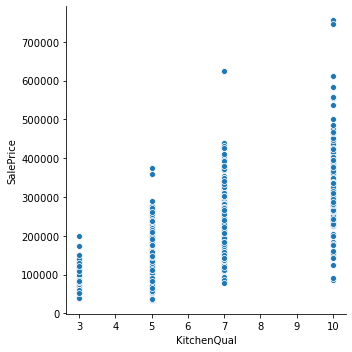

avg_Bmt_Qual


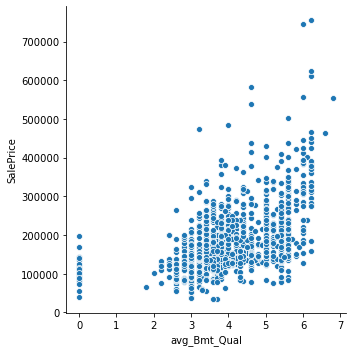

1stFlrSF


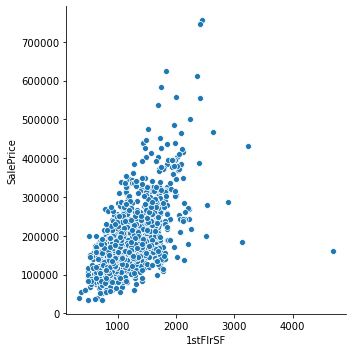

BsmtQual


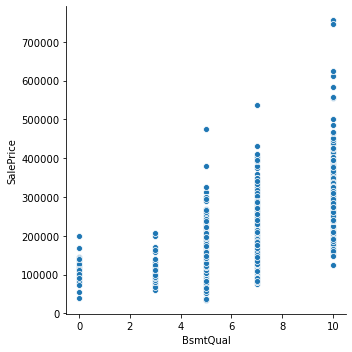

total_in_out_sqft


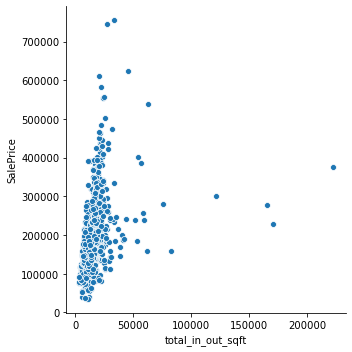

no_finishes


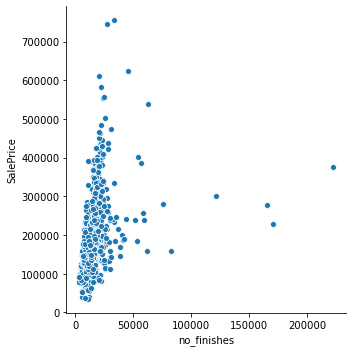

GarageYrBlt


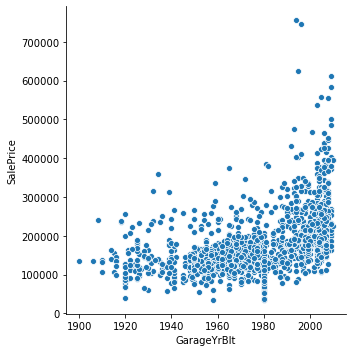

MSSubClass


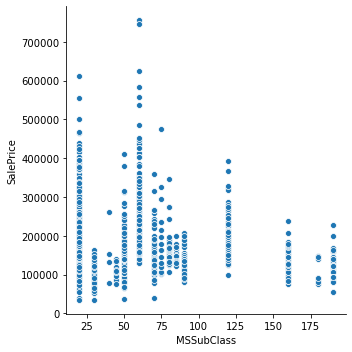

GarageFinish


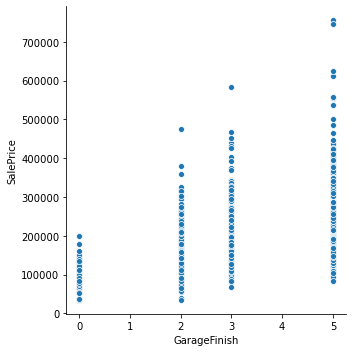

total_Garage_Ql_Cd


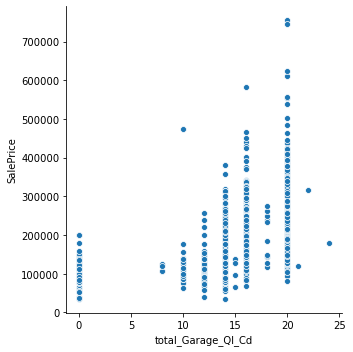

avg_Gar_Qual


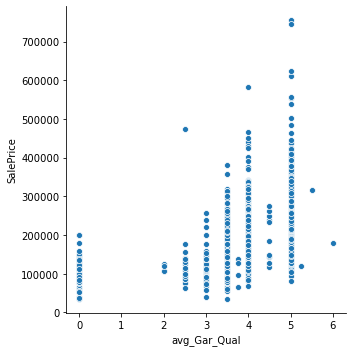

YrSd_YrRmd


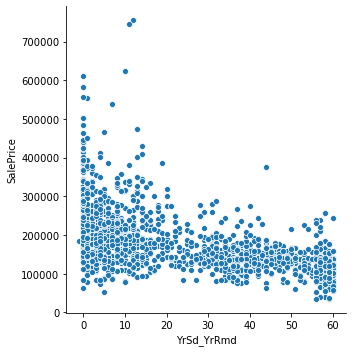

YearRemodAdd_Age


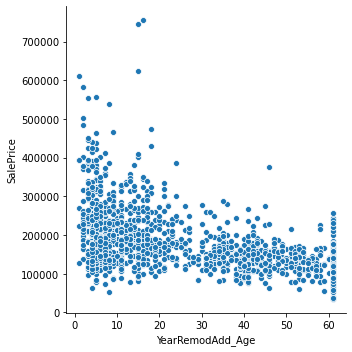

YearRemodAdd


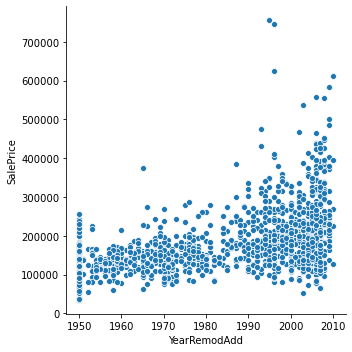

FullBath


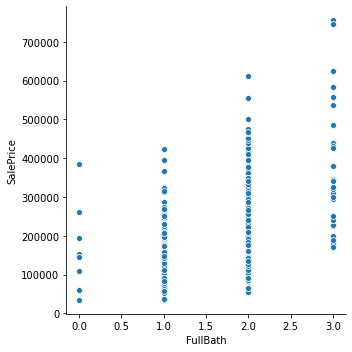

total_Ext_Ql_Cd


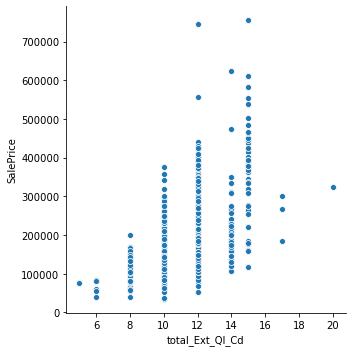

avg_Ext_Qual


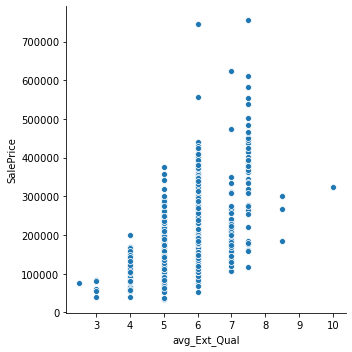

Foundation_MasVnrType


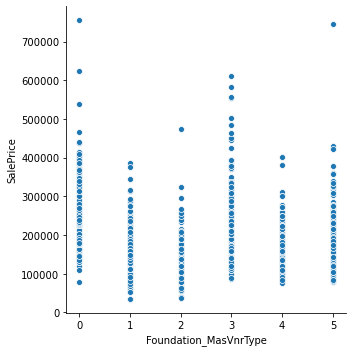

Garage_per_Car_Cap


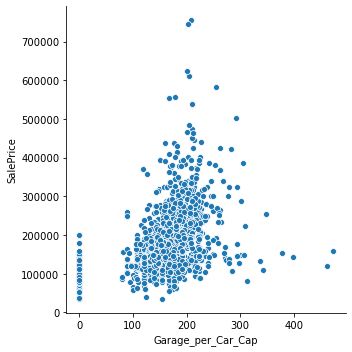

FireplaceQu


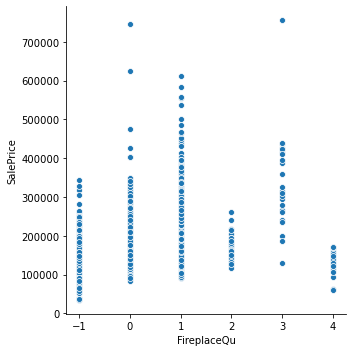

TotRmsAbvGrd


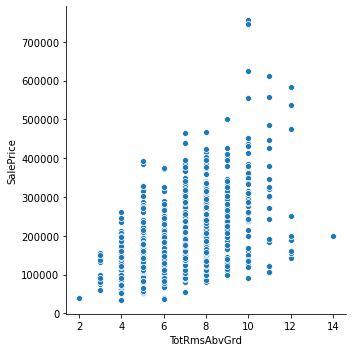

LotFrontage


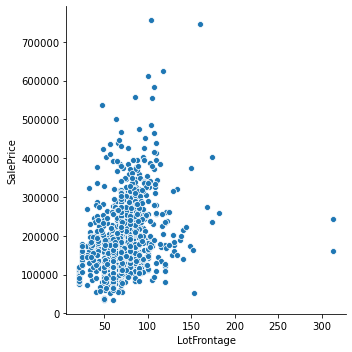

2ndFlrSF


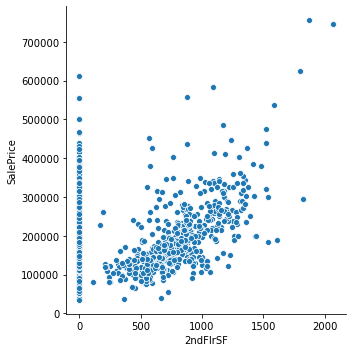

GarageType


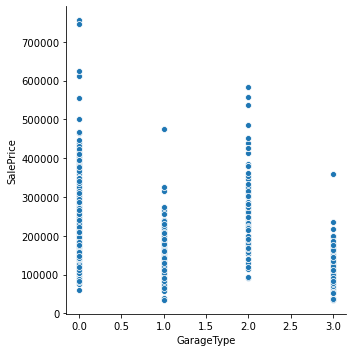

Foundation


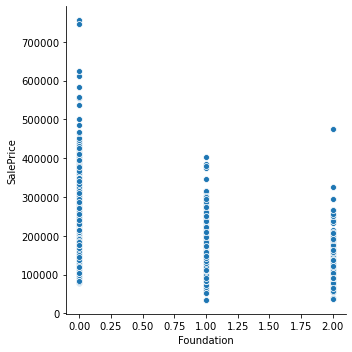

total_outdoor_sqft


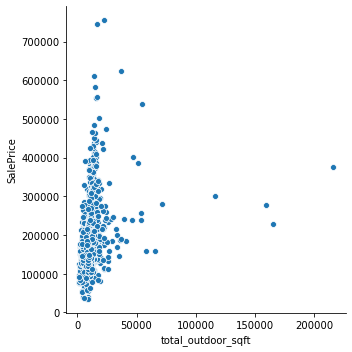

HeatingQC


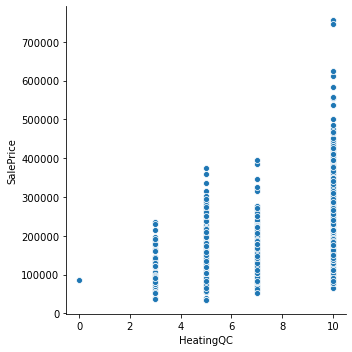

Exterior2nd


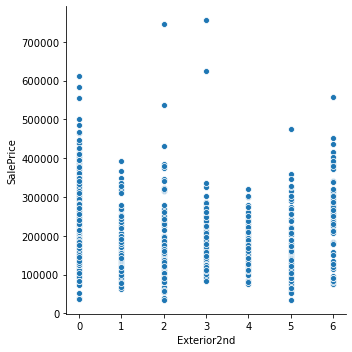

Fireplaces


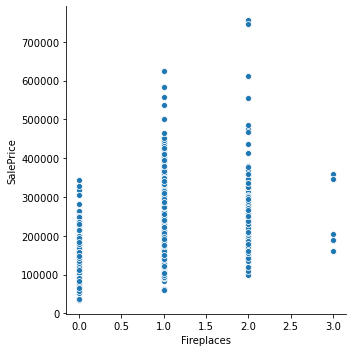

LotArea


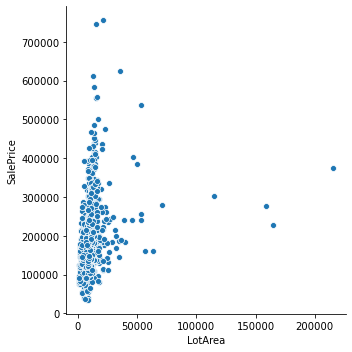

BsmtFinType1


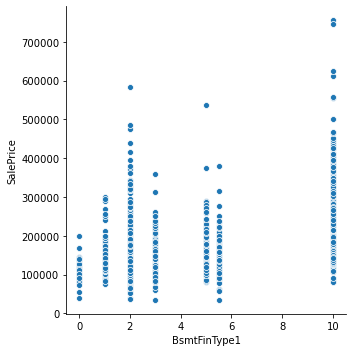

Exterior1st_Exterior2nd


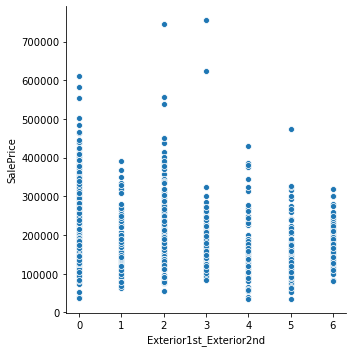

OpenPorchSF


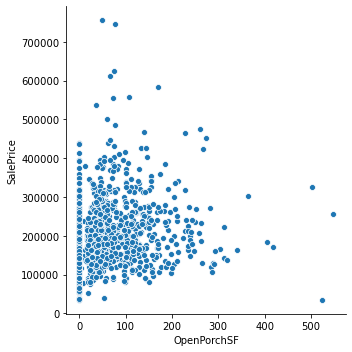

BsmtFinSF1


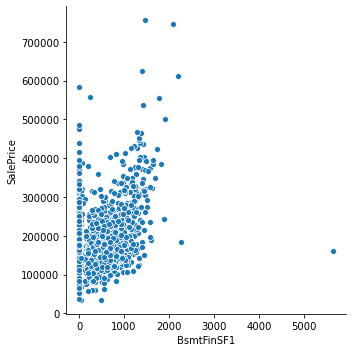

Exterior1st


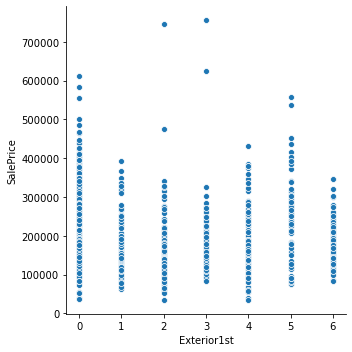

total_Bmt_Fn_Area


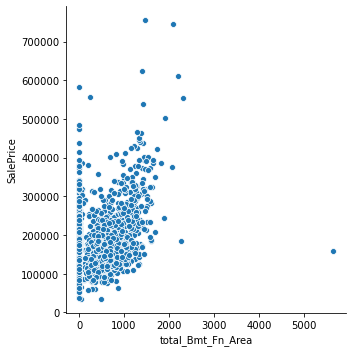

total_Max_Porch_Area


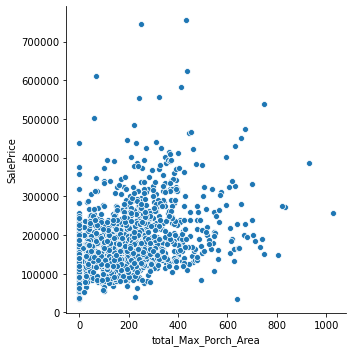

total_Porch


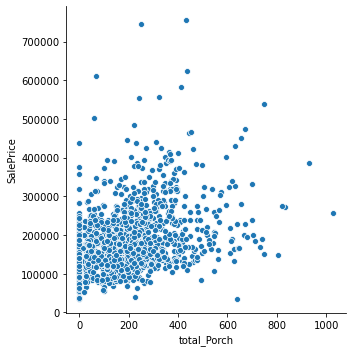

MSZoning


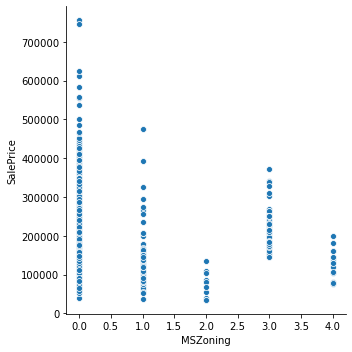

BsmtUnfSF


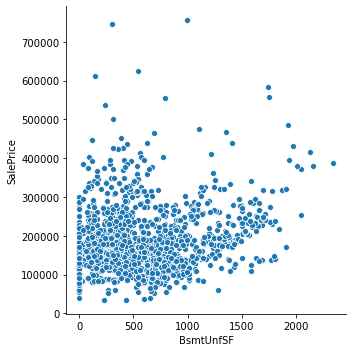

LotAreaPerFront


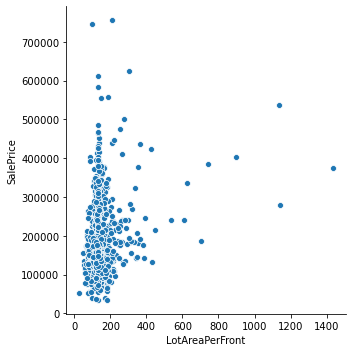

WoodDeckSF


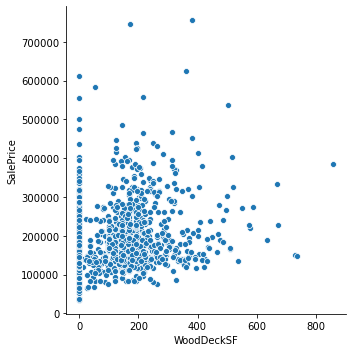

OverallCond


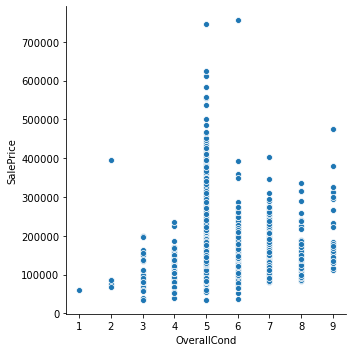

in_per_out


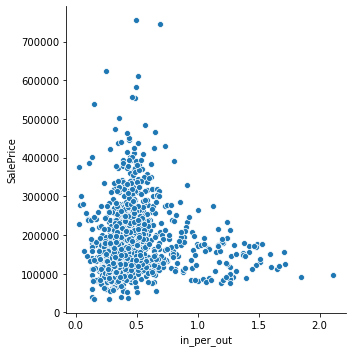

GarageCond


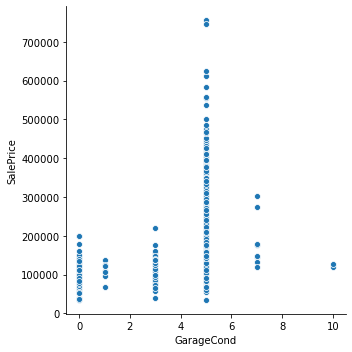

LotShape_LandContour


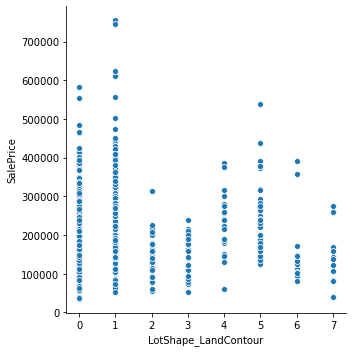

SaleType


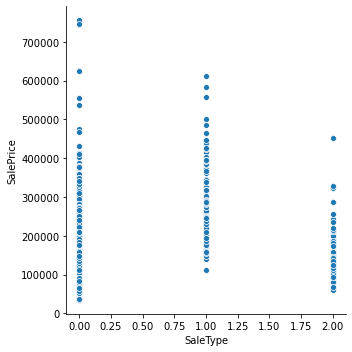

SaleCondition_SaleType


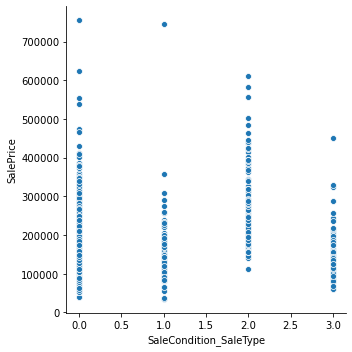

LotShape


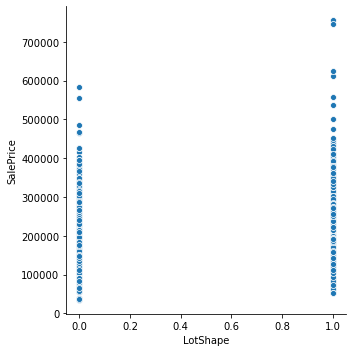

MasVnrType


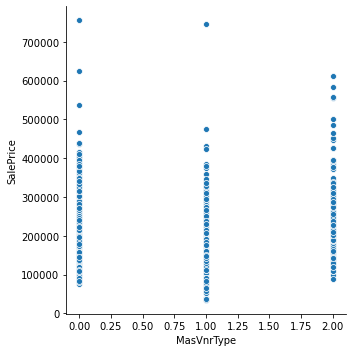

SaleCondition


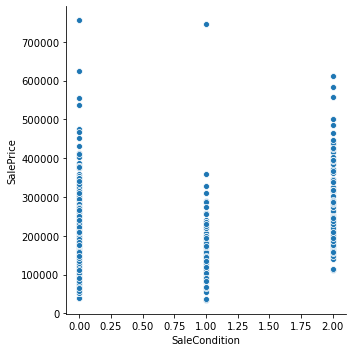

HalfBath


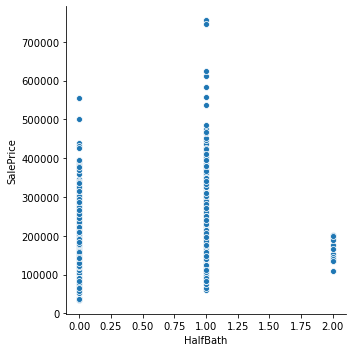

LotShape_LandSlope


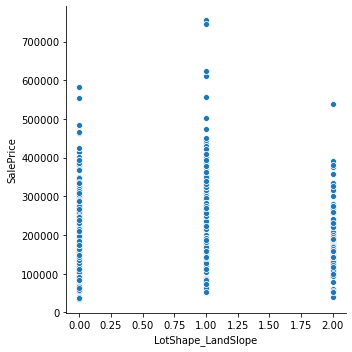

BsmtExposure


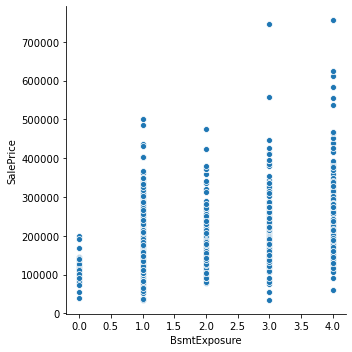

MasVnrArea


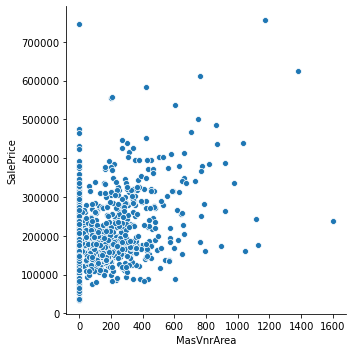

house_story


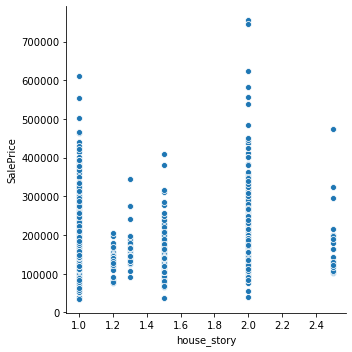

GarageQual


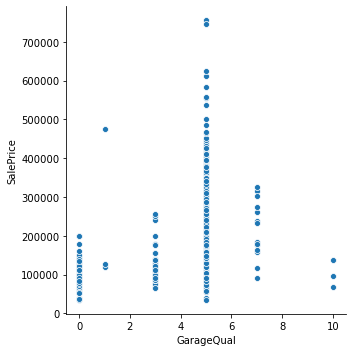

HouseStyle


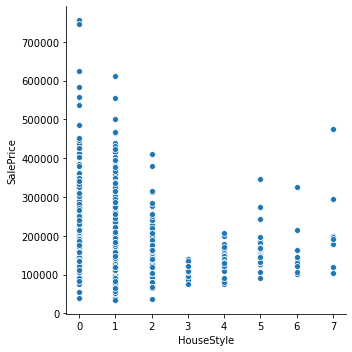

LotShape_LotConfig


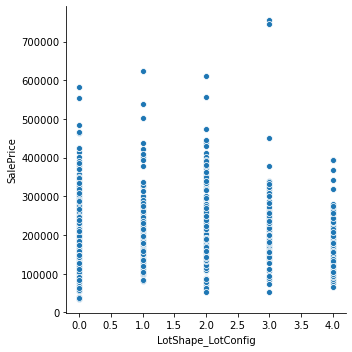

YrBlt_YrRmd_Diff


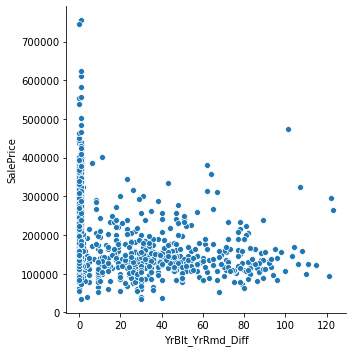

BedroomAbvGr


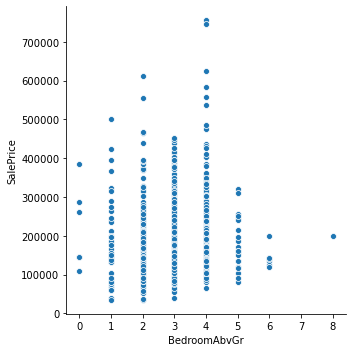

BsmtCond


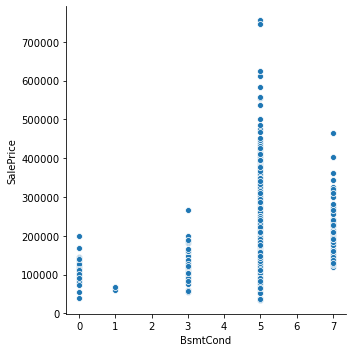

Bsmt_Unf_Per


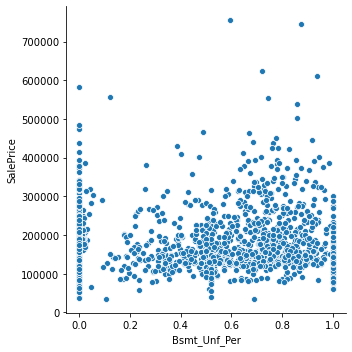

Bsmt_Fsh_Per


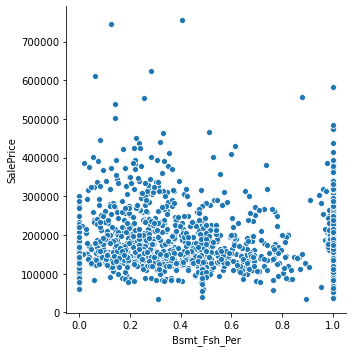

CentralAir


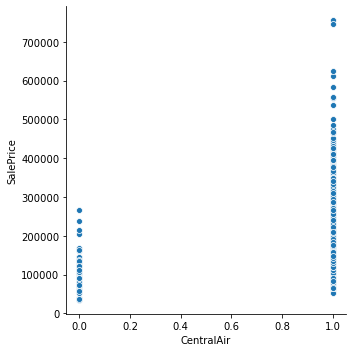

PavedDrive


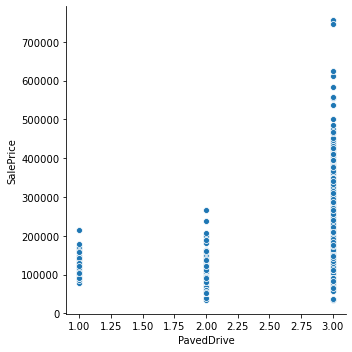

Electrical


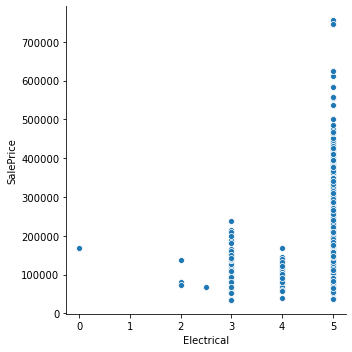

BldgType


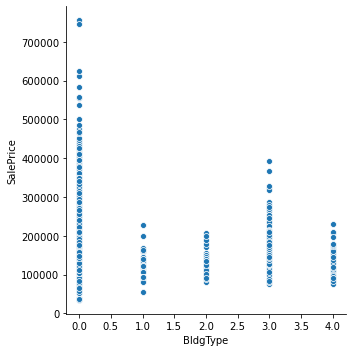

Fence


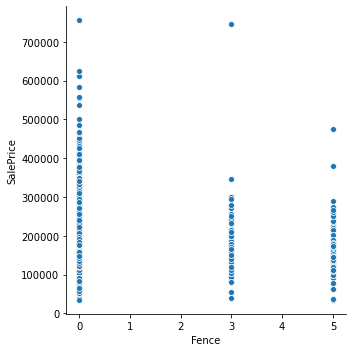

EnclosedPorch


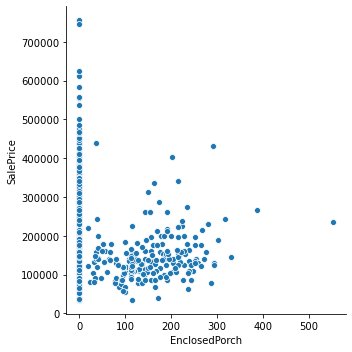

Remodeled


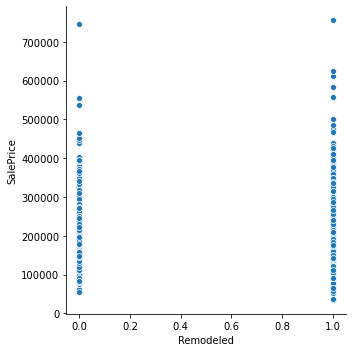

BsmtFinType2


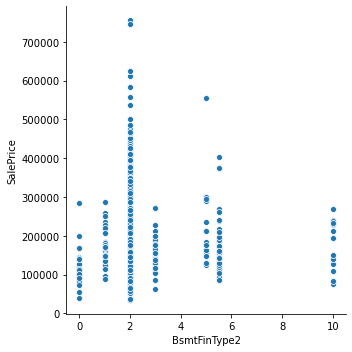

Street_Alley


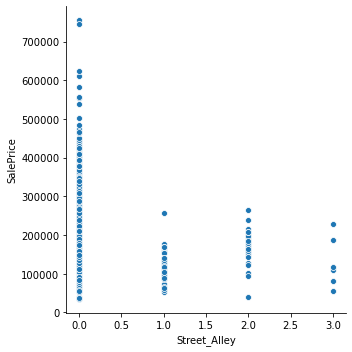

KitchenAbvGr


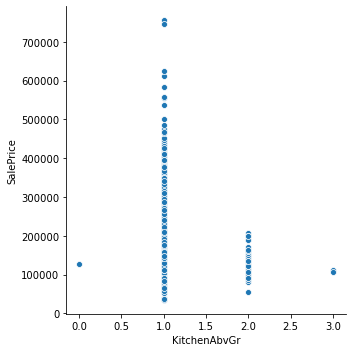

ExterCond


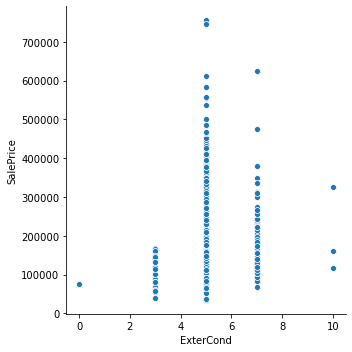

Condition1


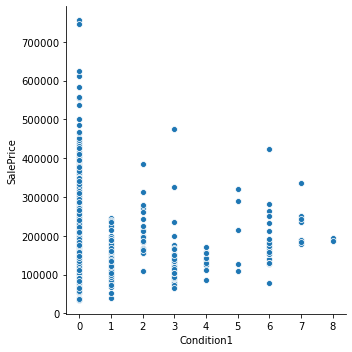

Alley


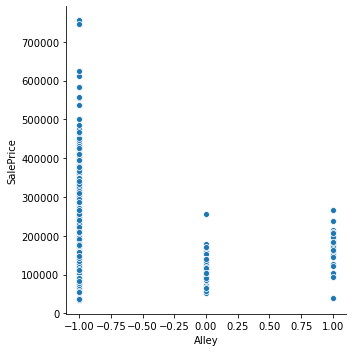

LandContour


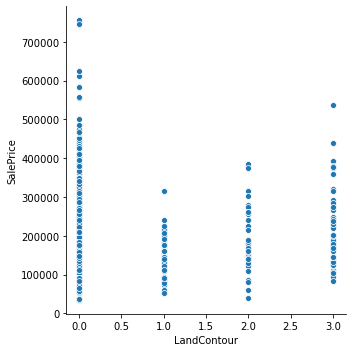

RoofStyle


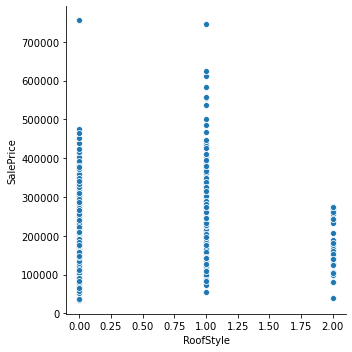

BsmtFullBath


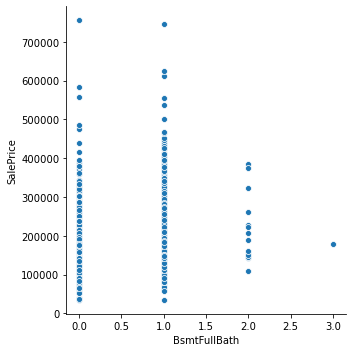

house_finish


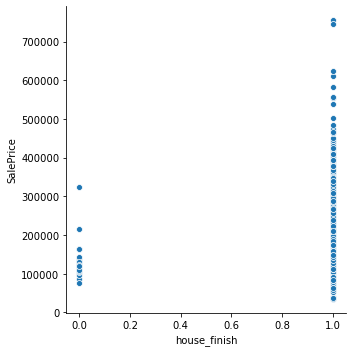

ScreenPorch


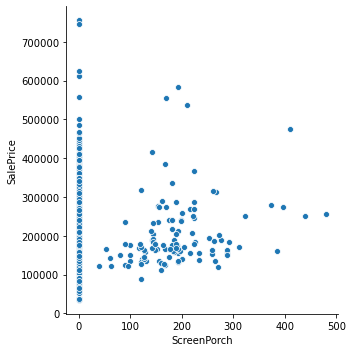

Functional


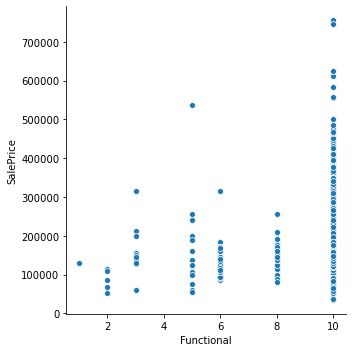

BsmtHalfBath


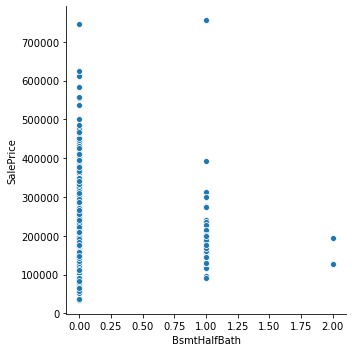

LotConfig


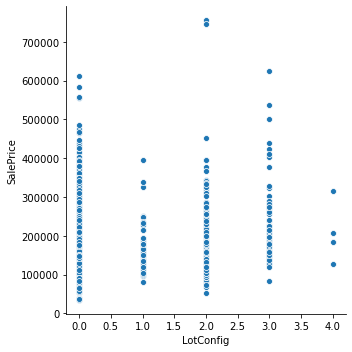

LandSlope


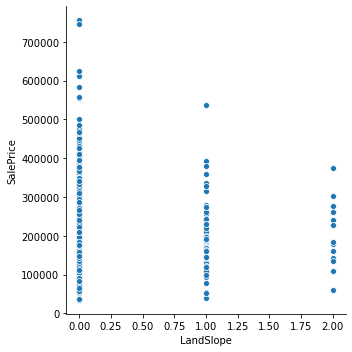

no_finishes_perc


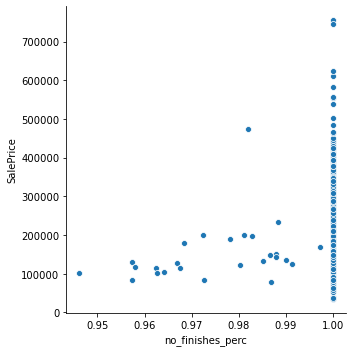

RoofMatl


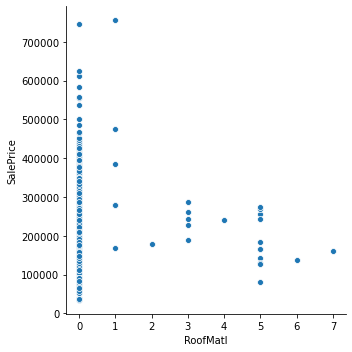

Heating


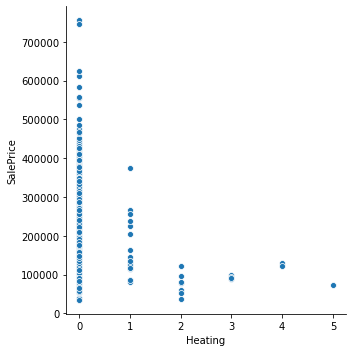

Street


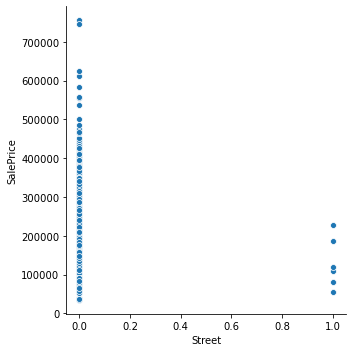

LowQualFinSF


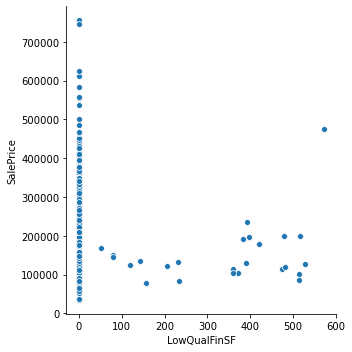

kfold


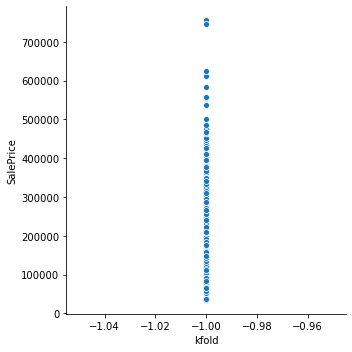

3SsnPorch


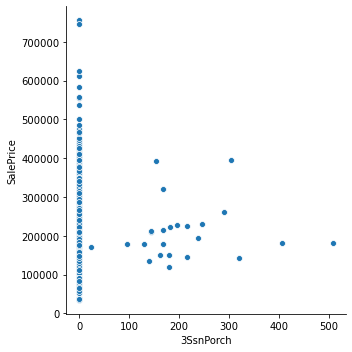

Condition2


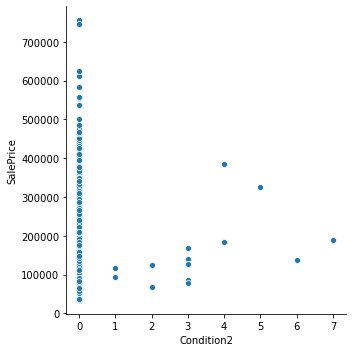

PoolArea


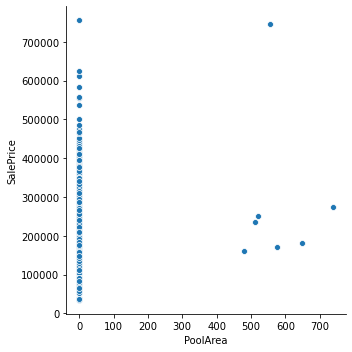

PoolQC


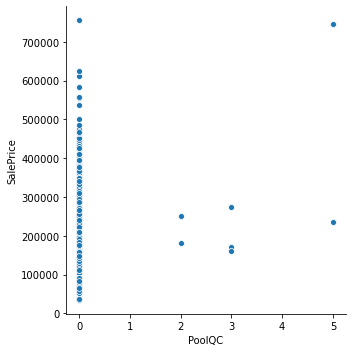

BsmtFinSF2


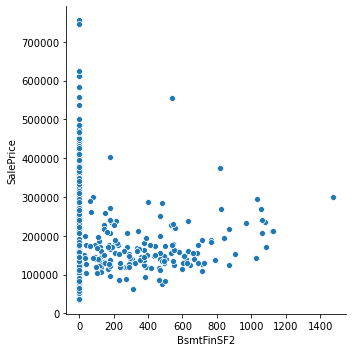

Utilities


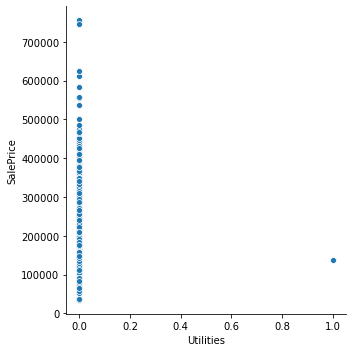

MiscFeature


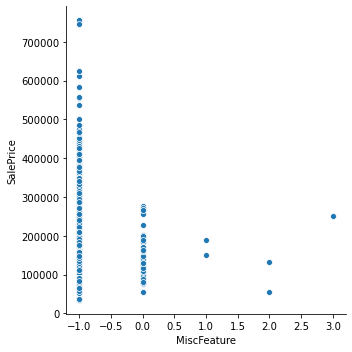

MiscVal


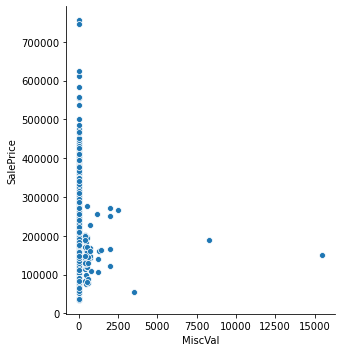

MoSold


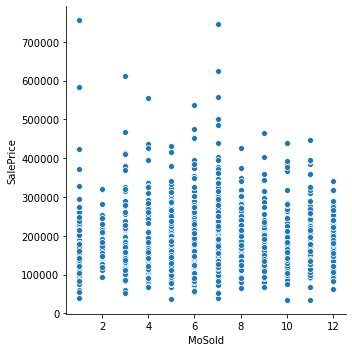

YrSold


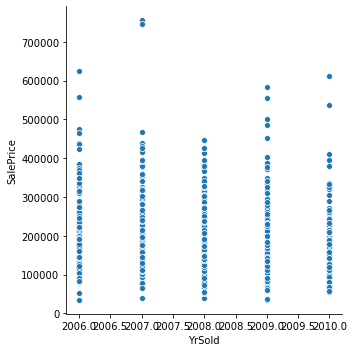

Condition1_Condition2


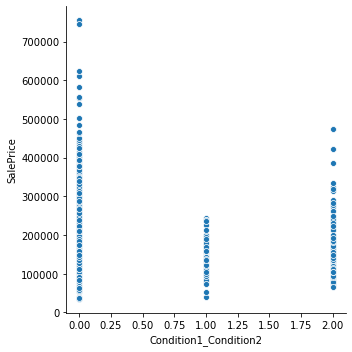

In [25]:
for col in mutual_mxLE:
    sns.relplot(x=col, y="SalePrice", data=mxLE);
    print(col)
    plt.show()
   

In [57]:
['a'] + ['b']

['a', 'b']

# mutual info label my ordinal encoded all features

In [109]:
#mutual Oordinal top 70
topK_mutual_mxLE = mutual_mxLE[:70]

for model in classifier_list:
    print('Model : ',model)
    RMSE_arr=[]
    for i in np.arange(5):
        
        score= run(df=train_df[topK_mutual_mxLE+['SalePrice']],target=target,model=model,fold=i,dropped=[],save_fold_csv=False)  ; RMSE_arr.append(score)
    print('')
    print('___mean_score___ = ', np.mean(RMSE_arr))
    print('===============================================')

Model :  RandomForestRegressor(n_estimators=200)
Fold = 0, RMSE = 25020.611075574212
Fold = 1, RMSE = 21290.364801861993
Fold = 2, RMSE = 25406.627402477654
Fold = 3, RMSE = 28099.950051566844
Fold = 4, RMSE = 42885.30122312718

___mean_score___ =  28540.570910921575
Model :  ExtraTreesRegressor(n_estimators=200)
Fold = 0, RMSE = 22182.136365759525
Fold = 1, RMSE = 25633.49633356107
Fold = 2, RMSE = 25927.20372997962
Fold = 3, RMSE = 23706.644278222935
Fold = 4, RMSE = 26712.497624982658

___mean_score___ =  24832.39566650116
Model :  LinearRegression()
Fold = 0, RMSE = 26920.911894556724
Fold = 1, RMSE = 55682.01194914889
Fold = 2, RMSE = 24035.523649056588
Fold = 3, RMSE = 28376.36872882648
Fold = 4, RMSE = 29283.94616771453

___mean_score___ =  32859.752477860646
Model :  Lasso()
Fold = 0, RMSE = 43947.41004246038
Fold = 1, RMSE = 37303.71649910777
Fold = 2, RMSE = 31265.079390385163
Fold = 3, RMSE = 29653.92830829609
Fold = 4, RMSE = 24860.51680404209

___mean_score___ =  33406.130

In [110]:
topK_mutual_mxLE = mutual_mxLE[:60]

for model in classifier_list:
    print('Model : ',model)
    RMSE_arr=[]
    for i in np.arange(5):
        
        score= run(df=train_df[topK_mutual_mxLE+['SalePrice']],target=target,model=model,fold=i,dropped=[],save_fold_csv=False)  ; RMSE_arr.append(score)
    print('')
    print('___mean_score___ = ', np.mean(RMSE_arr))
    print('===============================================')

Model :  RandomForestRegressor(n_estimators=200)
Fold = 0, RMSE = 33928.22899109572
Fold = 1, RMSE = 30793.70707435193
Fold = 2, RMSE = 28838.972208197545
Fold = 3, RMSE = 27147.48078684465
Fold = 4, RMSE = 28448.211542390196

___mean_score___ =  29831.320120576005
Model :  ExtraTreesRegressor(n_estimators=200)
Fold = 0, RMSE = 34536.19823931167
Fold = 1, RMSE = 24570.640225674095
Fold = 2, RMSE = 31214.554468280265
Fold = 3, RMSE = 24733.95122977804
Fold = 4, RMSE = 30630.17773999081

___mean_score___ =  29137.104380606976
Model :  LinearRegression()
Fold = 0, RMSE = 31059.05700820552
Fold = 1, RMSE = 36675.44328579893
Fold = 2, RMSE = 46628.98942828056
Fold = 3, RMSE = 34221.68965099136
Fold = 4, RMSE = 31062.04233830872

___mean_score___ =  35929.444342317016
Model :  Lasso()
Fold = 0, RMSE = 25010.86576849791
Fold = 1, RMSE = 35896.05291818344
Fold = 2, RMSE = 35216.87203318284
Fold = 3, RMSE = 46510.53162723871
Fold = 4, RMSE = 30773.652911314563

___mean_score___ =  34681.5950516

In [111]:
topK_mutual_mxLE = mutual_mxLE[:50]

for model in classifier_list:
    print('Model : ',model)
    RMSE_arr=[]
    for i in np.arange(5):
        
        score= run(df=train_df[topK_mutual_mxLE+['SalePrice']],target=target,model=model,fold=i,dropped=[],save_fold_csv=False)  ; RMSE_arr.append(score)
    print('')
    print('___mean_score___ = ', np.mean(RMSE_arr))
    print('===============================================')

Model :  RandomForestRegressor(n_estimators=200)
Fold = 0, RMSE = 24430.774442209055
Fold = 1, RMSE = 24541.932431883048
Fold = 2, RMSE = 23078.60075686791
Fold = 3, RMSE = 27002.356289894546
Fold = 4, RMSE = 33833.574546631025

___mean_score___ =  26577.447693497117
Model :  ExtraTreesRegressor(n_estimators=200)
Fold = 0, RMSE = 19695.99296938784
Fold = 1, RMSE = 24998.29026555215
Fold = 2, RMSE = 35014.780534486476
Fold = 3, RMSE = 31808.140181484396
Fold = 4, RMSE = 44096.14394452424

___mean_score___ =  31122.66957908702
Model :  LinearRegression()
Fold = 0, RMSE = 45167.69063208321
Fold = 1, RMSE = 42274.42127772772
Fold = 2, RMSE = 34972.9876700787
Fold = 3, RMSE = 27062.74018870039
Fold = 4, RMSE = 48479.099320377965

___mean_score___ =  39591.3878177936
Model :  Lasso()
Fold = 0, RMSE = 35627.16406358817
Fold = 1, RMSE = 39168.6037877898
Fold = 2, RMSE = 29026.197787129608
Fold = 3, RMSE = 37036.84106720541
Fold = 4, RMSE = 31948.907152260042

___mean_score___ =  34561.54277159

In [112]:
topK_mutual_mxLE = mutual_mxLE[:40]

for model in classifier_list:
    print('Model : ',model)
    RMSE_arr=[]
    for i in np.arange(5):
        
        score= run(df=train_df[topK_mutual_mxLE+['SalePrice']],target=target,model=model,fold=i,dropped=[],save_fold_csv=False)  ; RMSE_arr.append(score)
    print('')
    print('___mean_score___ = ', np.mean(RMSE_arr))
    print('===============================================')

Model :  RandomForestRegressor(n_estimators=200)
Fold = 0, RMSE = 24598.934190503667
Fold = 1, RMSE = 31568.56679398385
Fold = 2, RMSE = 24995.505138859273
Fold = 3, RMSE = 45814.682625333284
Fold = 4, RMSE = 29919.67387298401

___mean_score___ =  31379.472524332814
Model :  ExtraTreesRegressor(n_estimators=200)
Fold = 0, RMSE = 22514.704920693937
Fold = 1, RMSE = 26162.126227298733
Fold = 2, RMSE = 21902.496899861748
Fold = 3, RMSE = 48946.03272420088
Fold = 4, RMSE = 40742.21359006169

___mean_score___ =  32053.514872423395
Model :  LinearRegression()
Fold = 0, RMSE = 31611.728177858553
Fold = 1, RMSE = 26914.471432792907
Fold = 2, RMSE = 26222.256909263946
Fold = 3, RMSE = 41866.870161141545
Fold = 4, RMSE = 35187.23991746817

___mean_score___ =  32360.513319705024
Model :  Lasso()
Fold = 0, RMSE = 36342.89146368318
Fold = 1, RMSE = 31842.260893975315
Fold = 2, RMSE = 31243.932877313175
Fold = 3, RMSE = 33462.76001650647
Fold = 4, RMSE = 33434.510903151015

___mean_score___ =  33265

# Graph OHE

Fold = 0, RMSE = 24263.959418548944
Fold = 1, RMSE = 32786.825773618606
Fold = 2, RMSE = 31870.293018939035
Fold = 3, RMSE = 26095.577123450177
Fold = 4, RMSE = 27449.307274479783
k=  100  mean_score =  28493.19252180731
Fold = 0, RMSE = 27184.890145323585
Fold = 1, RMSE = 32554.799709959607
Fold = 2, RMSE = 33620.683369892526
Fold = 3, RMSE = 23243.083527154122
Fold = 4, RMSE = 24080.490068465653
k=  90  mean_score =  28136.789364159096
Fold = 0, RMSE = 27765.055320594525
Fold = 1, RMSE = 25725.066771227164
Fold = 2, RMSE = 28371.641697886815
Fold = 3, RMSE = 34041.465105709336
Fold = 4, RMSE = 28982.875836900395
k=  80  mean_score =  28977.220946463647
Fold = 0, RMSE = 42624.18929910312
Fold = 1, RMSE = 30281.002578065363
Fold = 2, RMSE = 30670.40962026451
Fold = 3, RMSE = 29889.905310546885
Fold = 4, RMSE = 34488.59085935131
k=  70  mean_score =  33590.81953346624
Fold = 0, RMSE = 23648.35402941431
Fold = 1, RMSE = 24044.29535720704
Fold = 2, RMSE = 34637.67698080489
Fold = 3, RMSE 

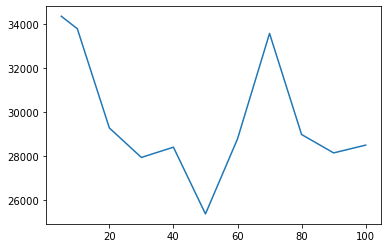

In [125]:
k_array = [100,90,80,70,60,50,40,30,20,10,5]
graph_mean_rf_O=[]
for k in k_array:
    topK_mutual_mxOHE = mutual_mxOHE[:k]
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=mxOHE[topK_mutual_mxOHE+['SalePrice']],target=target,model=rf,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    graph_mean_rf_O.append(np.mean(RMSE_arr))

sns.lineplot(k_array,graph_mean_rf_O)    
    



Fold = 0, RMSE = 25221.373224886076
Fold = 1, RMSE = 41149.927385657495
Fold = 2, RMSE = 35441.33615104471
Fold = 3, RMSE = 18546.409843493635
Fold = 4, RMSE = 33916.61530484395
k=  100  mean_score =  30855.132381985175
Fold = 0, RMSE = 20684.030141478583
Fold = 1, RMSE = 24128.415698537523
Fold = 2, RMSE = 32733.785848138563
Fold = 3, RMSE = 24033.285877805323
Fold = 4, RMSE = 27526.86494840331
k=  90  mean_score =  25821.27650287266
Fold = 0, RMSE = 23957.243533767265
Fold = 1, RMSE = 19558.4649993517
Fold = 2, RMSE = 27460.997410175267
Fold = 3, RMSE = 26012.2487062539
Fold = 4, RMSE = 22417.04898249177
k=  80  mean_score =  23881.20072640798
Fold = 0, RMSE = 25943.715461657157
Fold = 1, RMSE = 19519.67076028359
Fold = 2, RMSE = 43476.35526959395
Fold = 3, RMSE = 35865.48087064711
Fold = 4, RMSE = 26428.638431662002
k=  70  mean_score =  30246.772158768763
Fold = 0, RMSE = 26200.544520704607
Fold = 1, RMSE = 25153.142686618623
Fold = 2, RMSE = 24903.68367037161
Fold = 3, RMSE = 2995

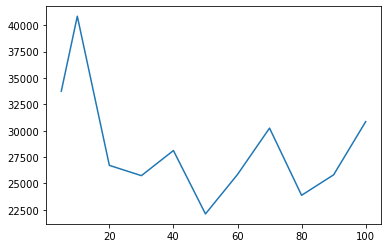

In [130]:
k_array = [100,90,80,70,60,50,40,30,20,10,5]
graph_mean_et_O=[]
for k in k_array:
    topK_mutual_mxOHE = mutual_mxOHE[:k]
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=mxOHE[topK_mutual_mxOHE+['SalePrice']],target=target,model=et,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    graph_mean_et_O.append(np.mean(RMSE_arr))

sns.lineplot(k_array,graph_mean_et_O)    
    



Fold = 0, RMSE = 22297.06321393355
Fold = 1, RMSE = 24980.52825456385
Fold = 2, RMSE = 21223.281509423457
Fold = 3, RMSE = 35356.87259265953
Fold = 4, RMSE = 26542.28521277442
k=  100  mean_score =  26080.00615667096
Fold = 0, RMSE = 26431.579653887657
Fold = 1, RMSE = 24688.66696391192
Fold = 2, RMSE = 26750.454417538676
Fold = 3, RMSE = 34980.758456955526
Fold = 4, RMSE = 27509.841630300358
k=  90  mean_score =  28072.260224518825
Fold = 0, RMSE = 19073.33869598048
Fold = 1, RMSE = 21556.72576495508
Fold = 2, RMSE = 22598.77090605212
Fold = 3, RMSE = 22130.92222064209
Fold = 4, RMSE = 23496.494404067314
k=  80  mean_score =  21771.25039833942
Fold = 0, RMSE = 26584.709141736184
Fold = 1, RMSE = 31982.835798300493
Fold = 2, RMSE = 34957.920137208464
Fold = 3, RMSE = 26254.227857936614
Fold = 4, RMSE = 36297.31346221337
k=  70  mean_score =  31215.401279479025
Fold = 0, RMSE = 19297.90617825532
Fold = 1, RMSE = 35347.165140225916
Fold = 2, RMSE = 21589.29862601091
Fold = 3, RMSE = 2439

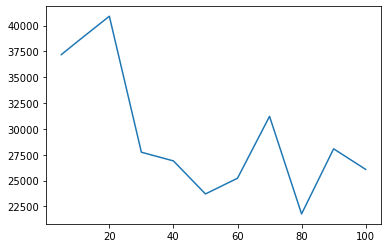

In [132]:
k_array = [100,90,80,70,60,50,40,30,20,10,5]
graph_mean_xgb_O=[]
for k in k_array:
    topK_mutual_mxOHE = mutual_mxOHE[:k]
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=mxOHE[topK_mutual_mxOHE+['SalePrice']],target=target,model=et,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    graph_mean_xgb_O.append(np.mean(RMSE_arr))

sns.lineplot(k_array,graph_mean_xgb_O)    
    



Fold = 0, RMSE = 27232.735168661795
Fold = 1, RMSE = 26446.0619537571
Fold = 2, RMSE = 24914.083996501333
Fold = 3, RMSE = 23283.743108223836
Fold = 4, RMSE = 29868.973857795907
k=  100  mean_score =  26349.11961698799
Fold = 0, RMSE = 26802.230013574357
Fold = 1, RMSE = 26978.47070321135
Fold = 2, RMSE = 25006.93667911842
Fold = 3, RMSE = 27592.83825604244
Fold = 4, RMSE = 25172.488985942007
k=  90  mean_score =  26310.592927577713
Fold = 0, RMSE = 29497.68835176601
Fold = 1, RMSE = 31147.658152004293
Fold = 2, RMSE = 25809.283288412847
Fold = 3, RMSE = 21321.16362984751
Fold = 4, RMSE = 35564.639341168215
k=  80  mean_score =  28668.086552639772
Fold = 0, RMSE = 40243.768520227095
Fold = 1, RMSE = 45609.82534724304
Fold = 2, RMSE = 24776.473433372954
Fold = 3, RMSE = 26790.04916471244
Fold = 4, RMSE = 26062.808837959787
k=  70  mean_score =  32696.585060703062
Fold = 0, RMSE = 49450.395252088674
Fold = 1, RMSE = 26997.927977474723
Fold = 2, RMSE = 26561.63965944146
Fold = 3, RMSE = 3

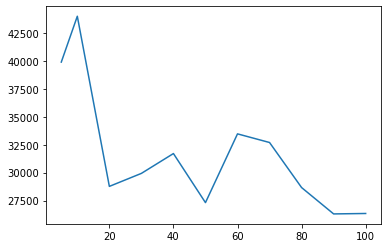

In [116]:
k_array = [100,90,80,70,60,50,40,30,20,10,5]
graph_mean=[]
for k in k_array:
    topK_mutual_mxOHE = mutual_mxOHE[:k]
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=mxOHE[topK_mutual_mxOHE+['SalePrice']],target=target,model=xgb,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    graph_mean.append(np.mean(RMSE_arr))

sns.lineplot(k_array,graph_mean)    
    



# GRAPH LE

Fold = 0, RMSE = 28851.75436275359
Fold = 1, RMSE = 32004.356752744316
Fold = 2, RMSE = 36020.82602337042
Fold = 3, RMSE = 32746.739059821237
Fold = 4, RMSE = 29436.659121605164
k=  100  mean_score =  31812.067064058945
Fold = 0, RMSE = 28906.289474769295
Fold = 1, RMSE = 26569.60851404498
Fold = 2, RMSE = 22439.543963206837
Fold = 3, RMSE = 25640.353448118036
Fold = 4, RMSE = 22957.242584491934
k=  90  mean_score =  25302.60759692622
Fold = 0, RMSE = 31294.160042260173
Fold = 1, RMSE = 24131.656086692754
Fold = 2, RMSE = 27719.39327774081
Fold = 3, RMSE = 28502.487830604277
Fold = 4, RMSE = 24691.595234185534
k=  80  mean_score =  27267.85849429671
Fold = 0, RMSE = 20233.754013671438
Fold = 1, RMSE = 22050.842408530698
Fold = 2, RMSE = 31689.014235865023
Fold = 3, RMSE = 42185.79320785661
Fold = 4, RMSE = 25094.801152951542
k=  70  mean_score =  28250.841003775062
Fold = 0, RMSE = 30728.80908029254
Fold = 1, RMSE = 32449.773218448026
Fold = 2, RMSE = 20540.289887935767
Fold = 3, RMSE 

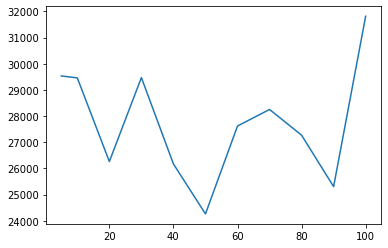

In [117]:
k_array = [100,90,80,70,60,50,40,30,20,10,5]
graph_mean=[]
for k in k_array:
    topK_mutual_mxLE = mutual_mxLE[:k]
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=train_df[topK_mutual_mxLE+['SalePrice']],target=target,model=rf,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    graph_mean.append(np.mean(RMSE_arr))

sns.lineplot(k_array,graph_mean)    
    



Fold = 0, RMSE = 24812.993678625822
Fold = 1, RMSE = 25659.808384255728
Fold = 2, RMSE = 43490.35473257202
Fold = 3, RMSE = 33878.98845597019
Fold = 4, RMSE = 36460.480253433794
k=  100  mean_score =  32860.525100971514
Fold = 0, RMSE = 22313.015085719213
Fold = 1, RMSE = 23181.348874282263
Fold = 2, RMSE = 24980.273860058845
Fold = 3, RMSE = 25537.89266897263
Fold = 4, RMSE = 28643.101760761623
k=  90  mean_score =  24931.126449958912
Fold = 0, RMSE = 29330.43991711868
Fold = 1, RMSE = 26323.632115944572
Fold = 2, RMSE = 34188.32095601614
Fold = 3, RMSE = 24462.43128116065
Fold = 4, RMSE = 33587.96236739088
k=  80  mean_score =  29578.557327526185
Fold = 0, RMSE = 33479.09503313738
Fold = 1, RMSE = 24222.504487538732
Fold = 2, RMSE = 23595.311132179057
Fold = 3, RMSE = 28191.638656768646
Fold = 4, RMSE = 21373.263025395434
k=  70  mean_score =  26172.36246700385
Fold = 0, RMSE = 23372.878020278313
Fold = 1, RMSE = 24095.9092825686
Fold = 2, RMSE = 33457.5787232038
Fold = 3, RMSE = 224

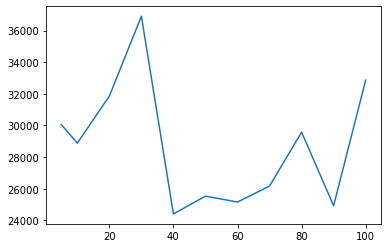

In [119]:
k_array = [100,90,80,70,60,50,40,30,20,10,5]
graph_mean_et=[]
for k in k_array:
    topK_mutual_mxLE = mutual_mxLE[:k]
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=train_df[topK_mutual_mxLE+['SalePrice']],target=target,model=et,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    graph_mean_et.append(np.mean(RMSE_arr))

sns.lineplot(k_array,graph_mean_et)    
    



In [121]:
graph_mean_et

[32860.525100971514,
 24931.126449958912,
 29578.557327526185,
 26172.36246700385,
 25163.119586379507,
 25536.153942390876,
 24413.037530074675,
 36902.27664076408,
 31857.602728245995,
 28884.117347628082,
 30058.06563119478]

In [122]:
graph_mean

[31812.067064058945,
 25302.60759692622,
 27267.85849429671,
 28250.841003775062,
 27618.67076319982,
 24260.34694897292,
 26169.374223154584,
 29467.802699560816,
 26261.187358518877,
 29457.127572010213,
 29530.96331042148]

In [124]:
graph_mean_xgb

[32946.31225067892,
 30839.87269026346,
 29200.547321985905,
 33346.17342097884,
 26754.29585626906,
 29558.522123532242,
 26672.727750826783,
 28259.30208595951,
 31835.849449165013,
 27925.2551904717,
 38895.122356819105]

Fold = 0, RMSE = 24015.356472338197
Fold = 1, RMSE = 51251.20708295761
Fold = 2, RMSE = 24142.669318881995
Fold = 3, RMSE = 36412.883802550095
Fold = 4, RMSE = 28909.44457666672
k=  100  mean_score =  32946.31225067892
Fold = 0, RMSE = 27000.883882294736
Fold = 1, RMSE = 47504.154110345036
Fold = 2, RMSE = 26024.649534257358
Fold = 3, RMSE = 27001.097144239116
Fold = 4, RMSE = 26668.578780181044
k=  90  mean_score =  30839.87269026346
Fold = 0, RMSE = 26919.86483059823
Fold = 1, RMSE = 38984.95873834121
Fold = 2, RMSE = 23969.54365690031
Fold = 3, RMSE = 29766.69899405071
Fold = 4, RMSE = 26361.670390039093
k=  80  mean_score =  29200.547321985905
Fold = 0, RMSE = 31189.211301054784
Fold = 1, RMSE = 24064.825504482946
Fold = 2, RMSE = 30549.098325540406
Fold = 3, RMSE = 52268.88898244735
Fold = 4, RMSE = 28658.842991368692
k=  70  mean_score =  33346.17342097884
Fold = 0, RMSE = 25996.075971328464
Fold = 1, RMSE = 28993.98901524644
Fold = 2, RMSE = 25802.116787030736
Fold = 3, RMSE = 2

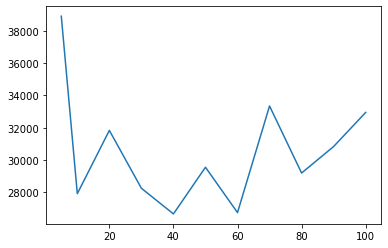

In [123]:
k_array = [100,90,80,70,60,50,40,30,20,10,5]
graph_mean_xgb=[]
for k in k_array:
    topK_mutual_mxLE = mutual_mxLE[:k]
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=train_df[topK_mutual_mxLE+['SalePrice']],target=target,model=xgb,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    graph_mean_xgb.append(np.mean(RMSE_arr))

sns.lineplot(k_array,graph_mean_xgb)    
    



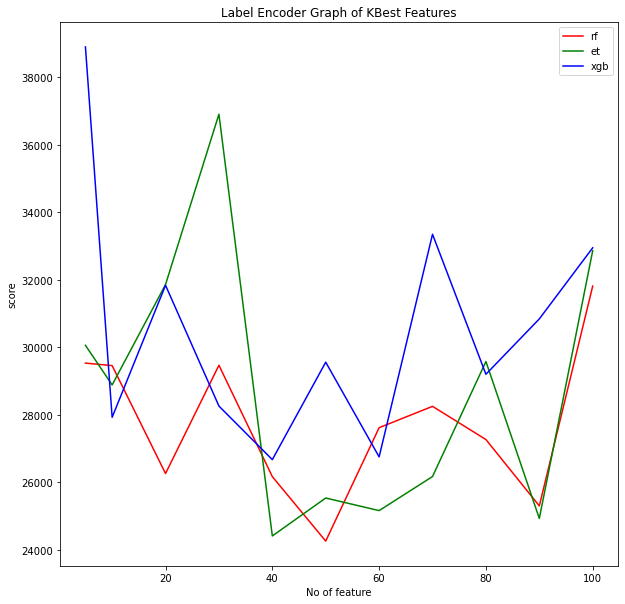

In [133]:
plt.figure(figsize=(10,10))
plt.title("Label Encoder Graph of KBest Features")
plt.xlabel("No of feature")
plt.ylabel("score")
plt.plot(k_array,graph_mean,'r',label='rf')
plt.plot(k_array,graph_mean_et,'g',label='et')
plt.plot(k_array,graph_mean_xgb,'b',label='xgb')
plt.legend()

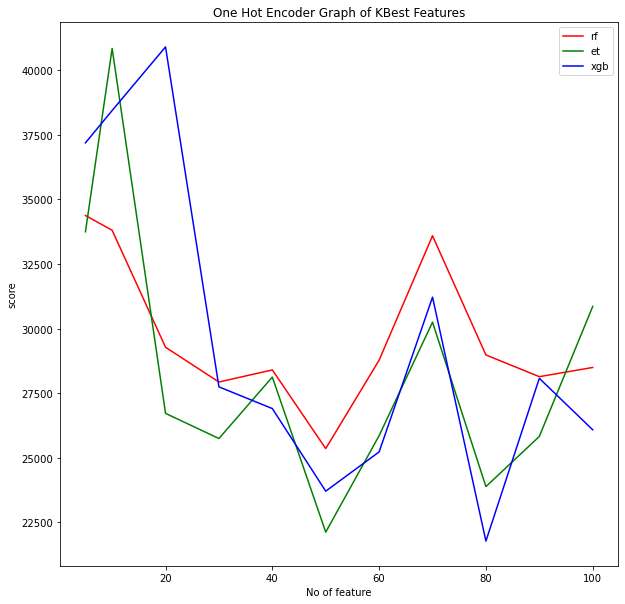

In [138]:
plt.figure(figsize=(10,10))
plt.title("One Hot Encoder Graph of KBest Features")
plt.xlabel("No of feature")
plt.ylabel("score")
plt.plot(k_array,graph_mean_rf_O,'r',label='rf')
plt.plot(k_array,graph_mean_et_O,'g',label='et')
plt.plot(k_array,graph_mean_xgb_O,'b',label='xgb')
plt.legend()

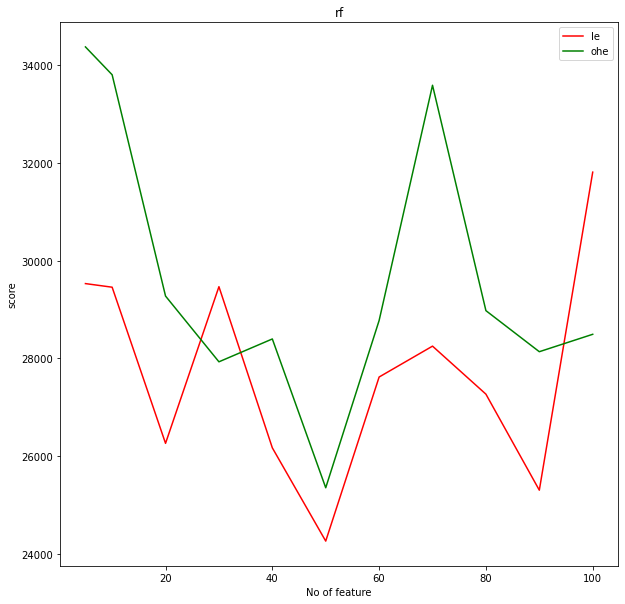

In [134]:
plt.figure(figsize=(10,10))
plt.title("rf")
plt.xlabel("No of feature")
plt.ylabel("score")
plt.plot(k_array,graph_mean,'r',label='le')
plt.plot(k_array,graph_mean_rf_O,'g',label='ohe')
#plt.plot(k_array,graph_mean_xgb,'b',label='xgb')
plt.legend()

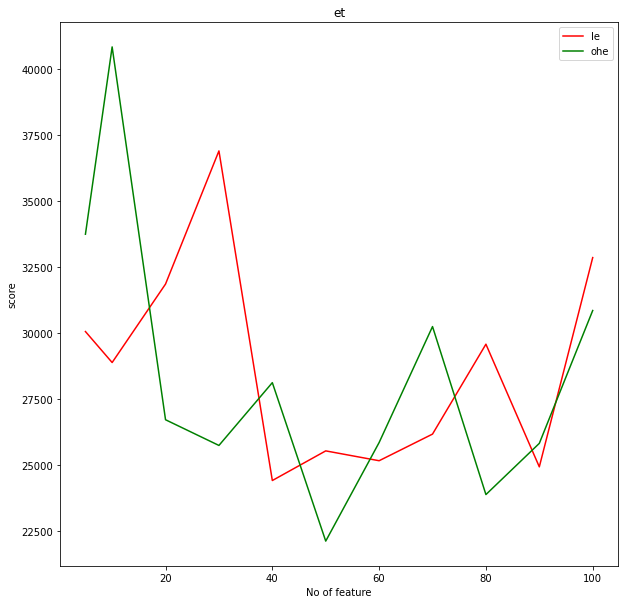

In [135]:
plt.figure(figsize=(10,10))
plt.title("et")
plt.xlabel("No of feature")
plt.ylabel("score")
plt.plot(k_array,graph_mean_et,'r',label='le')
plt.plot(k_array,graph_mean_et_O,'g',label='ohe')
#plt.plot(k_array,graph_mean_xgb,'b',label='xgb')
plt.legend()

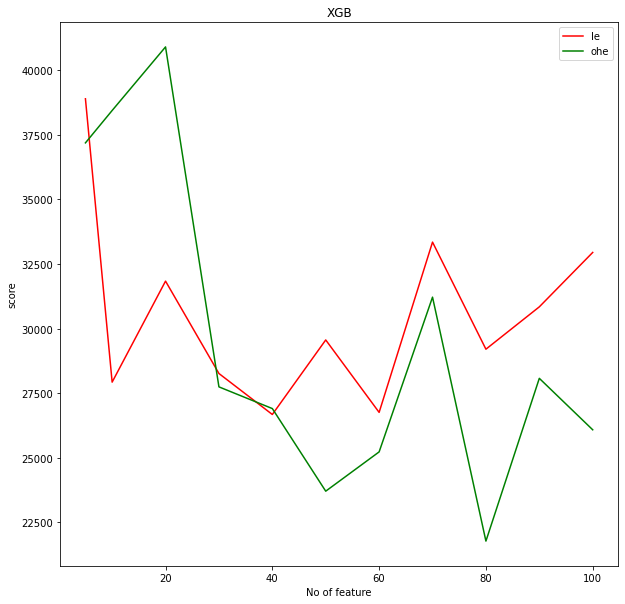

In [136]:
plt.figure(figsize=(10,10))
plt.title("XGB")
plt.xlabel("No of feature")
plt.ylabel("score")
plt.plot(k_array,graph_mean_xgb,'r',label='le')
plt.plot(k_array,graph_mean_xgb_O,'g',label='ohe')
#plt.plot(k_array,graph_mean_xgb,'b',label='xgb')
plt.legend()

In [58]:

for model in classifier_list:
    print('Model : ',model)
    for i in np.arange(5):
        RMSE_arr=[]
        score= run(df=train_df[topK_mutual_mxLE+['SalePrice']],target=target,model=model,fold=i,dropped=[],save_fold_csv=False)  ; RMSE_arr.append(score)
    print('')
    print('___mean_score___ = ', np.mean(RMSE_arr))
    print('===============================================')

Model :  RandomForestRegressor(n_estimators=200)
Fold = 0, RMSE = 44991.444959952794
Fold = 1, RMSE = 22270.184027978357
Fold = 2, RMSE = 24800.936139032958
Fold = 3, RMSE = 31686.177423909983
Fold = 4, RMSE = 23790.83238273154

___mean_score___ =  23790.83238273154
Model :  ExtraTreesRegressor(n_estimators=200)
Fold = 0, RMSE = 35364.879803577394
Fold = 1, RMSE = 24874.779566637844
Fold = 2, RMSE = 26632.774444177914
Fold = 3, RMSE = 23264.98089007183
Fold = 4, RMSE = 25326.08461721978

___mean_score___ =  25326.08461721978
Model :  LinearRegression()
Fold = 0, RMSE = 35857.29519565738
Fold = 1, RMSE = 28942.071421834877
Fold = 2, RMSE = 30456.374330994066
Fold = 3, RMSE = 26989.29037559393
Fold = 4, RMSE = 31052.265171209106

___mean_score___ =  31052.265171209106
Model :  Lasso()
Fold = 0, RMSE = 31421.531274434114
Fold = 1, RMSE = 39201.92037063223
Fold = 2, RMSE = 26163.18185034919
Fold = 3, RMSE = 44199.31972040833
Fold = 4, RMSE = 27220.64412815337

___mean_score___ =  27220.644

In [60]:
#mutual Oordinal top 30
topK_mutual_mxLE = mutual_mxLE[:30]

# mutual info label my onehot encoded all features 60

In [94]:
#top 60
model_score={}
for model in classifier_list:
    print('Model : ',model)
    #model_score[model]=
    for i in np.arange(5):
        RMSE_arr=[]
        score= run(df=mxOHE[topK_mutual_mxOHE+['SalePrice']],target=target,model=model,fold=i,dropped=[],save_fold_csv=False)   
        RMSE_arr.append(score)
    print('')
    print('___mean_score___ = ', np.mean(RMSE_arr))
    print('===============================================')

Model :  RandomForestRegressor(n_estimators=200)
Fold = 0, RMSE = 26170.221461501806
Fold = 1, RMSE = 34227.47417485587
Fold = 2, RMSE = 30477.951936847716
Fold = 3, RMSE = 25611.46025189174
Fold = 4, RMSE = 23377.878917675796

___mean_score___ =  23377.878917675796
Model :  ExtraTreesRegressor(n_estimators=200)
Fold = 0, RMSE = 27232.914808675854
Fold = 1, RMSE = 26089.941525268354
Fold = 2, RMSE = 20841.05165282764
Fold = 3, RMSE = 28915.78231641959
Fold = 4, RMSE = 26462.99476904025

___mean_score___ =  26462.99476904025
Model :  LinearRegression()
Fold = 0, RMSE = 27598.58075161901
Fold = 1, RMSE = 44708.618544130615
Fold = 2, RMSE = 27897.986709362394
Fold = 3, RMSE = 47332.459013404405
Fold = 4, RMSE = 44691.453986245644

___mean_score___ =  44691.453986245644
Model :  Lasso()
Fold = 0, RMSE = 36271.402999823746
Fold = 1, RMSE = 34222.46741864061
Fold = 2, RMSE = 32533.565270889612
Fold = 3, RMSE = 32181.472424727275
Fold = 4, RMSE = 31321.852304320328

___mean_score___ =  31321.